# 1. load data

In [1]:
import random
import numpy as np
import torch
import torch.utils.data as Data
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

import pypianoroll as ppr
import pretty_midi
from pypianoroll import Multitrack, Track
from matplotlib import pyplot as plt

In [2]:
from vae_rnn import *

run on GPU


In [3]:
random.seed(0)

In [4]:
train_x_reduced = np.load('./../explore_data/data/train_x_drum_reduced.npy')
print(train_x_reduced.shape)

(34452, 96, 9)


In [5]:
NUM_EPOCHS = 50
BATCH_SIZE = 256

TESTING_RATIO = 0.1
N_DATA = train_x_reduced.shape[0]
N_TRAINING = int(train_x_reduced.shape[0]*TESTING_RATIO)
N_TESTING = N_DATA - N_TRAINING

In [6]:
def pltReducedDrumTrack(track, beat_resolution=12, cmap='Blues'):
    track = np.append(track, np.zeros((track.shape[0], 119)), axis=1)
    # track = np.where(track == 1, 128, 0)
    track = track * 128
    track = Track(pianoroll=track)
    
    fig, axs = track.plot(
        xtick='beat',
        yticklabel='number',
        beat_resolution=beat_resolution,
        cmap=cmap,
    )
    fig.set_size_inches(30,10)
    y = axs.set_ylim(0, 10) # C0 - C2
    y = axs.set_yticks(range(10))
    plt.show()

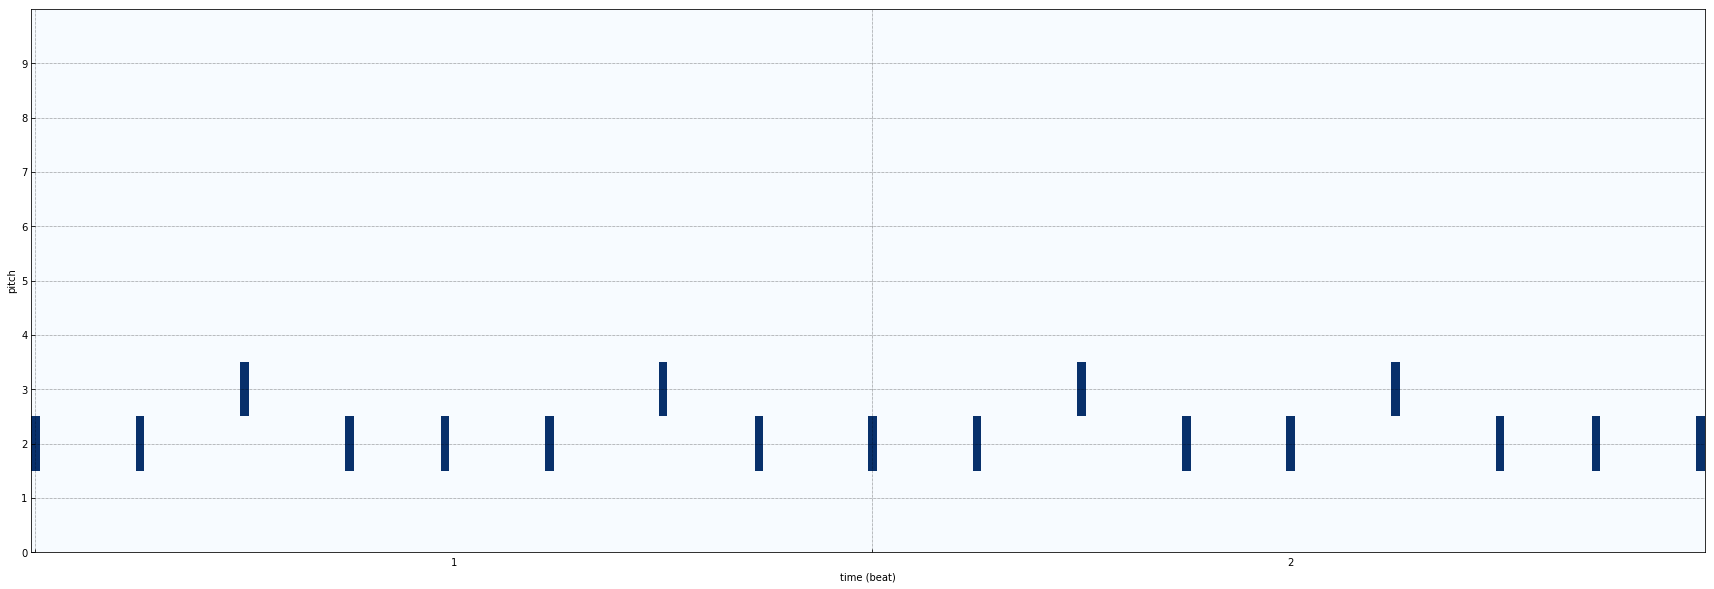

In [7]:
# draw some samples
number = 1
offset = 0
length = 2
for i in range(number):
    tracks = train_x_reduced[i*length+offset]
    for j in range(length - 1):
        tracks = np.concatenate((tracks, train_x_reduced[i*length+j+1+offset]), axis=0)
    pltReducedDrumTrack(tracks, 96)

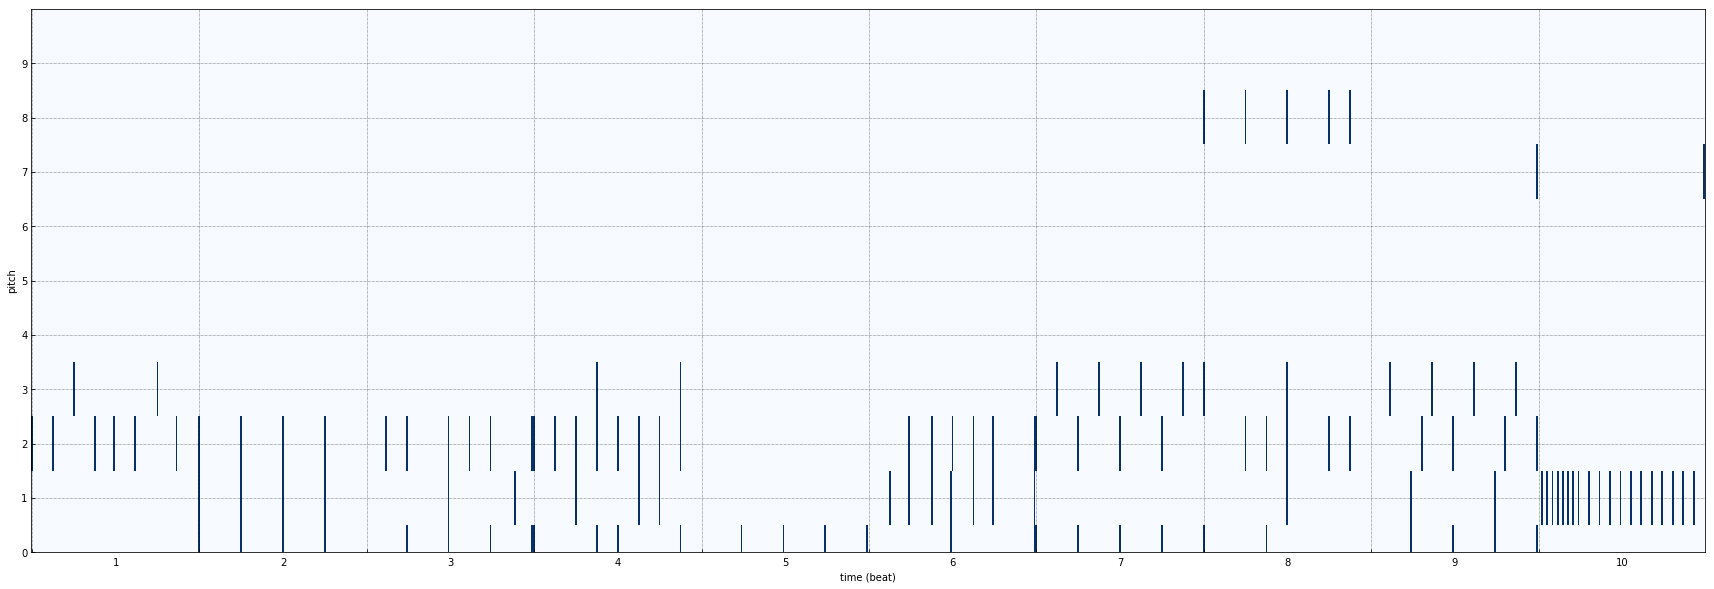

In [8]:
# draw random samples
random.seed(100)
number = 1
offset = 0
length = 10
for i in range(number):
    tracks = train_x_reduced[i*length+offset]
    for j in range(length - 1):
        tracks = np.concatenate((tracks, train_x_reduced[random.randint(0, train_x_reduced.shape[0])]), axis=0)
    pltReducedDrumTrack(tracks, 96)
    

In [9]:
def parse_data(training_data):
    ratio = TESTING_RATIO
    T = int(training_data.shape[0]*ratio)
    
    train_x = training_data[:-T]
    test_x = training_data[-T:]

    train_x = torch.from_numpy(train_x).type(torch.FloatTensor)
    test_x = torch.from_numpy(test_x).type(torch.FloatTensor)
    
    return train_x, test_x

# 2. training

In [10]:
train_x, test_x = parse_data(train_x_reduced)
train_dataset = Data.TensorDataset(train_x)
test_dataset = Data.TensorDataset(test_x)

train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=1,
)
test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=1,
)

In [11]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
vae = VAE(encoder, decoder).to(device)

optimizer = optim.Adam(vae.parameters(), lr=LR)
err = 0

In [12]:
device

device(type='cuda')

In [13]:
for epoch in range(NUM_EPOCHS):
    loss_sum = 0
    for batch_i, data in enumerate(train_loader):
        data = Variable(data[0]).type(torch.float32).to(device)
        optimizer.zero_grad()
        data_out = vae(data)
        
        loss = elbo(
            data_out,
            data,
            vae.z_mean,
            vae.z_sigma)
        loss.backward()
        optimizer.step()

        loss_sum += loss.data.item()
        
        if batch_i % 5 == 0:
            print('Train Epoch: {} [{:4d}/{} ({:2.0f}%)]      Loss: {:.6f}'.format(
                epoch,
                batch_i * BATCH_SIZE,
                len(train_loader.dataset),
                100. * batch_i / len(train_loader),
                loss.data.item() / BATCH_SIZE))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, loss_sum / len(train_loader.dataset)))

    
    if epoch % 5 == 0:
        loss_sum_test = 0
        for batch_i, data in enumerate(test_loader):
            with torch.no_grad():
                data = Variable(data[0]).type(torch.float32).to(device)
                data_out = vae(data)

                loss = F.binary_cross_entropy(
                    data_out,
                    data,
                    reduction='sum'
                )
                loss_sum_test += loss.item()

        print('====> Testing Average Loss: {}'.format(
            loss_sum_test / len(test_loader.dataset)))
        err = loss_sum_test / len(test_loader.dataset)

Train Epoch: 0 [   0/31007 ( 0%)]      Loss: 646.524719
Train Epoch: 0 [1280/31007 ( 4%)]      Loss: 619.666016
Train Epoch: 0 [2560/31007 ( 8%)]      Loss: 644.181396
Train Epoch: 0 [3840/31007 (12%)]      Loss: 590.099365
Train Epoch: 0 [5120/31007 (17%)]      Loss: 577.046448
Train Epoch: 0 [6400/31007 (21%)]      Loss: 588.319641
Train Epoch: 0 [7680/31007 (25%)]      Loss: 553.693298
Train Epoch: 0 [8960/31007 (29%)]      Loss: 543.077637
Train Epoch: 0 [10240/31007 (33%)]      Loss: 532.417053
Train Epoch: 0 [11520/31007 (37%)]      Loss: 522.504150
Train Epoch: 0 [12800/31007 (41%)]      Loss: 512.524780
Train Epoch: 0 [14080/31007 (45%)]      Loss: 502.238403
Train Epoch: 0 [15360/31007 (50%)]      Loss: 492.805878
Train Epoch: 0 [16640/31007 (54%)]      Loss: 483.328888
Train Epoch: 0 [17920/31007 (58%)]      Loss: 474.187592
Train Epoch: 0 [19200/31007 (62%)]      Loss: 465.750519
Train Epoch: 0 [20480/31007 (66%)]      Loss: 461.038452
Train Epoch: 0 [21760/31007 (70%)]     

Train Epoch: 5 [20480/31007 (66%)]      Loss: 97.061028
Train Epoch: 5 [21760/31007 (70%)]      Loss: 93.911980
Train Epoch: 5 [23040/31007 (74%)]      Loss: 95.037704
Train Epoch: 5 [24320/31007 (79%)]      Loss: 92.010185
Train Epoch: 5 [25600/31007 (83%)]      Loss: 93.717804
Train Epoch: 5 [26880/31007 (87%)]      Loss: 91.696854
Train Epoch: 5 [28160/31007 (91%)]      Loss: 90.066879
Train Epoch: 5 [29440/31007 (95%)]      Loss: 90.684280
Train Epoch: 5 [30720/31007 (99%)]      Loss: 88.709610
====> Epoch: 5 Average loss: 99.0080
====> Testing Average Loss: 91.48930231767054
Train Epoch: 6 [   0/31007 ( 0%)]      Loss: 88.325722
Train Epoch: 6 [1280/31007 ( 4%)]      Loss: 90.284698
Train Epoch: 6 [2560/31007 ( 8%)]      Loss: 88.907524
Train Epoch: 6 [3840/31007 (12%)]      Loss: 86.000000
Train Epoch: 6 [5120/31007 (17%)]      Loss: 88.785866
Train Epoch: 6 [6400/31007 (21%)]      Loss: 86.570602
Train Epoch: 6 [7680/31007 (25%)]      Loss: 85.827133
Train Epoch: 6 [8960/31007 (

Train Epoch: 11 [8960/31007 (29%)]      Loss: 46.089600
Train Epoch: 11 [10240/31007 (33%)]      Loss: 47.022469
Train Epoch: 11 [11520/31007 (37%)]      Loss: 45.564503
Train Epoch: 11 [12800/31007 (41%)]      Loss: 44.742985
Train Epoch: 11 [14080/31007 (45%)]      Loss: 46.390926
Train Epoch: 11 [15360/31007 (50%)]      Loss: 44.633389
Train Epoch: 11 [16640/31007 (54%)]      Loss: 43.980957
Train Epoch: 11 [17920/31007 (58%)]      Loss: 45.363239
Train Epoch: 11 [19200/31007 (62%)]      Loss: 45.991489
Train Epoch: 11 [20480/31007 (66%)]      Loss: 44.334583
Train Epoch: 11 [21760/31007 (70%)]      Loss: 44.617764
Train Epoch: 11 [23040/31007 (74%)]      Loss: 43.524158
Train Epoch: 11 [24320/31007 (79%)]      Loss: 42.296558
Train Epoch: 11 [25600/31007 (83%)]      Loss: 44.095627
Train Epoch: 11 [26880/31007 (87%)]      Loss: 44.476688
Train Epoch: 11 [28160/31007 (91%)]      Loss: 43.870850
Train Epoch: 11 [29440/31007 (95%)]      Loss: 43.767651
Train Epoch: 11 [30720/31007 (99

Train Epoch: 16 [29440/31007 (95%)]      Loss: 29.392136
Train Epoch: 16 [30720/31007 (99%)]      Loss: 30.951248
====> Epoch: 16 Average loss: 31.3570
Train Epoch: 17 [   0/31007 ( 0%)]      Loss: 30.447042
Train Epoch: 17 [1280/31007 ( 4%)]      Loss: 31.403910
Train Epoch: 17 [2560/31007 ( 8%)]      Loss: 29.111267
Train Epoch: 17 [3840/31007 (12%)]      Loss: 29.536354
Train Epoch: 17 [5120/31007 (17%)]      Loss: 31.158966
Train Epoch: 17 [6400/31007 (21%)]      Loss: 28.150206
Train Epoch: 17 [7680/31007 (25%)]      Loss: 27.697121
Train Epoch: 17 [8960/31007 (29%)]      Loss: 29.610174
Train Epoch: 17 [10240/31007 (33%)]      Loss: 31.313562
Train Epoch: 17 [11520/31007 (37%)]      Loss: 28.805761
Train Epoch: 17 [12800/31007 (41%)]      Loss: 27.826624
Train Epoch: 17 [14080/31007 (45%)]      Loss: 29.946035
Train Epoch: 17 [15360/31007 (50%)]      Loss: 27.663961
Train Epoch: 17 [16640/31007 (54%)]      Loss: 31.293207
Train Epoch: 17 [17920/31007 (58%)]      Loss: 27.942865
T

Train Epoch: 22 [16640/31007 (54%)]      Loss: 25.125486
Train Epoch: 22 [17920/31007 (58%)]      Loss: 24.426838
Train Epoch: 22 [19200/31007 (62%)]      Loss: 24.457994
Train Epoch: 22 [20480/31007 (66%)]      Loss: 22.676189
Train Epoch: 22 [21760/31007 (70%)]      Loss: 24.469530
Train Epoch: 22 [23040/31007 (74%)]      Loss: 23.565289
Train Epoch: 22 [24320/31007 (79%)]      Loss: 25.146469
Train Epoch: 22 [25600/31007 (83%)]      Loss: 23.037947
Train Epoch: 22 [26880/31007 (87%)]      Loss: 21.169935
Train Epoch: 22 [28160/31007 (91%)]      Loss: 22.267311
Train Epoch: 22 [29440/31007 (95%)]      Loss: 24.234756
Train Epoch: 22 [30720/31007 (99%)]      Loss: 20.954048
====> Epoch: 22 Average loss: 24.0173
Train Epoch: 23 [   0/31007 ( 0%)]      Loss: 20.931883
Train Epoch: 23 [1280/31007 ( 4%)]      Loss: 22.517969
Train Epoch: 23 [2560/31007 ( 8%)]      Loss: 23.543533
Train Epoch: 23 [3840/31007 (12%)]      Loss: 21.890234
Train Epoch: 23 [5120/31007 (17%)]      Loss: 22.10141

Train Epoch: 28 [3840/31007 (12%)]      Loss: 20.008102
Train Epoch: 28 [5120/31007 (17%)]      Loss: 18.774492
Train Epoch: 28 [6400/31007 (21%)]      Loss: 21.135311
Train Epoch: 28 [7680/31007 (25%)]      Loss: 20.449905
Train Epoch: 28 [8960/31007 (29%)]      Loss: 17.982992
Train Epoch: 28 [10240/31007 (33%)]      Loss: 20.041365
Train Epoch: 28 [11520/31007 (37%)]      Loss: 20.307457
Train Epoch: 28 [12800/31007 (41%)]      Loss: 19.691534
Train Epoch: 28 [14080/31007 (45%)]      Loss: 20.050188
Train Epoch: 28 [15360/31007 (50%)]      Loss: 20.578957
Train Epoch: 28 [16640/31007 (54%)]      Loss: 17.976427
Train Epoch: 28 [17920/31007 (58%)]      Loss: 20.424587
Train Epoch: 28 [19200/31007 (62%)]      Loss: 20.504145
Train Epoch: 28 [20480/31007 (66%)]      Loss: 20.202452
Train Epoch: 28 [21760/31007 (70%)]      Loss: 20.681639
Train Epoch: 28 [23040/31007 (74%)]      Loss: 20.046270
Train Epoch: 28 [24320/31007 (79%)]      Loss: 18.427452
Train Epoch: 28 [25600/31007 (83%)] 

Train Epoch: 33 [24320/31007 (79%)]      Loss: 19.497202
Train Epoch: 33 [25600/31007 (83%)]      Loss: 18.303570
Train Epoch: 33 [26880/31007 (87%)]      Loss: 17.397799
Train Epoch: 33 [28160/31007 (91%)]      Loss: 16.010075
Train Epoch: 33 [29440/31007 (95%)]      Loss: 19.992628
Train Epoch: 33 [30720/31007 (99%)]      Loss: 19.111565
====> Epoch: 33 Average loss: 18.1088
Train Epoch: 34 [   0/31007 ( 0%)]      Loss: 16.927809
Train Epoch: 34 [1280/31007 ( 4%)]      Loss: 20.279028
Train Epoch: 34 [2560/31007 ( 8%)]      Loss: 16.657335
Train Epoch: 34 [3840/31007 (12%)]      Loss: 17.717291
Train Epoch: 34 [5120/31007 (17%)]      Loss: 20.665440
Train Epoch: 34 [6400/31007 (21%)]      Loss: 18.305145
Train Epoch: 34 [7680/31007 (25%)]      Loss: 19.076551
Train Epoch: 34 [8960/31007 (29%)]      Loss: 20.053450
Train Epoch: 34 [10240/31007 (33%)]      Loss: 16.684633
Train Epoch: 34 [11520/31007 (37%)]      Loss: 18.887831
Train Epoch: 34 [12800/31007 (41%)]      Loss: 18.605890
T

Train Epoch: 39 [11520/31007 (37%)]      Loss: 15.398727
Train Epoch: 39 [12800/31007 (41%)]      Loss: 15.930307
Train Epoch: 39 [14080/31007 (45%)]      Loss: 18.015541
Train Epoch: 39 [15360/31007 (50%)]      Loss: 15.938503
Train Epoch: 39 [16640/31007 (54%)]      Loss: 15.678753
Train Epoch: 39 [17920/31007 (58%)]      Loss: 16.296247
Train Epoch: 39 [19200/31007 (62%)]      Loss: 16.916933
Train Epoch: 39 [20480/31007 (66%)]      Loss: 16.256245
Train Epoch: 39 [21760/31007 (70%)]      Loss: 15.636305
Train Epoch: 39 [23040/31007 (74%)]      Loss: 17.257242
Train Epoch: 39 [24320/31007 (79%)]      Loss: 15.181953
Train Epoch: 39 [25600/31007 (83%)]      Loss: 16.336884
Train Epoch: 39 [26880/31007 (87%)]      Loss: 16.515244
Train Epoch: 39 [28160/31007 (91%)]      Loss: 16.017162
Train Epoch: 39 [29440/31007 (95%)]      Loss: 16.737175
Train Epoch: 39 [30720/31007 (99%)]      Loss: 17.653051
====> Epoch: 39 Average loss: 16.2671
Train Epoch: 40 [   0/31007 ( 0%)]      Loss: 16.2

Train Epoch: 45 [   0/31007 ( 0%)]      Loss: 15.258639
Train Epoch: 45 [1280/31007 ( 4%)]      Loss: 15.791917
Train Epoch: 45 [2560/31007 ( 8%)]      Loss: 14.842840
Train Epoch: 45 [3840/31007 (12%)]      Loss: 13.176082
Train Epoch: 45 [5120/31007 (17%)]      Loss: 14.164717
Train Epoch: 45 [6400/31007 (21%)]      Loss: 14.468319
Train Epoch: 45 [7680/31007 (25%)]      Loss: 15.874386
Train Epoch: 45 [8960/31007 (29%)]      Loss: 13.411317
Train Epoch: 45 [10240/31007 (33%)]      Loss: 15.385003
Train Epoch: 45 [11520/31007 (37%)]      Loss: 16.434921
Train Epoch: 45 [12800/31007 (41%)]      Loss: 15.987733
Train Epoch: 45 [14080/31007 (45%)]      Loss: 15.351496
Train Epoch: 45 [15360/31007 (50%)]      Loss: 14.999848
Train Epoch: 45 [16640/31007 (54%)]      Loss: 17.587269
Train Epoch: 45 [17920/31007 (58%)]      Loss: 14.577874
Train Epoch: 45 [19200/31007 (62%)]      Loss: 13.626915
Train Epoch: 45 [20480/31007 (66%)]      Loss: 13.731071
Train Epoch: 45 [21760/31007 (70%)]    

In [14]:
from decimal import Decimal
sn_loss = '%.0E' % Decimal(err)
sn_lr = '%.0E' % Decimal(LR)

model_file_name = '_'.join([
    './models/model',
    'L{}'.format(sn_lr),
    'loss{}'.format(sn_loss),
     ACTIVATION,
    'gru{}'.format(GRU_HIDDEN_SIZE),
    'e{}'.format(NUM_EPOCHS),
    'b{}'.format(BATCH_SIZE)])

print(model_file_name)
torch.save(vae.state_dict(), model_file_name + '.pt')

./models/model_L5E-03_loss2E+01_relu_gru16_e50_b256


# 3. reconstruction

0.9999776 1.5140314e-07


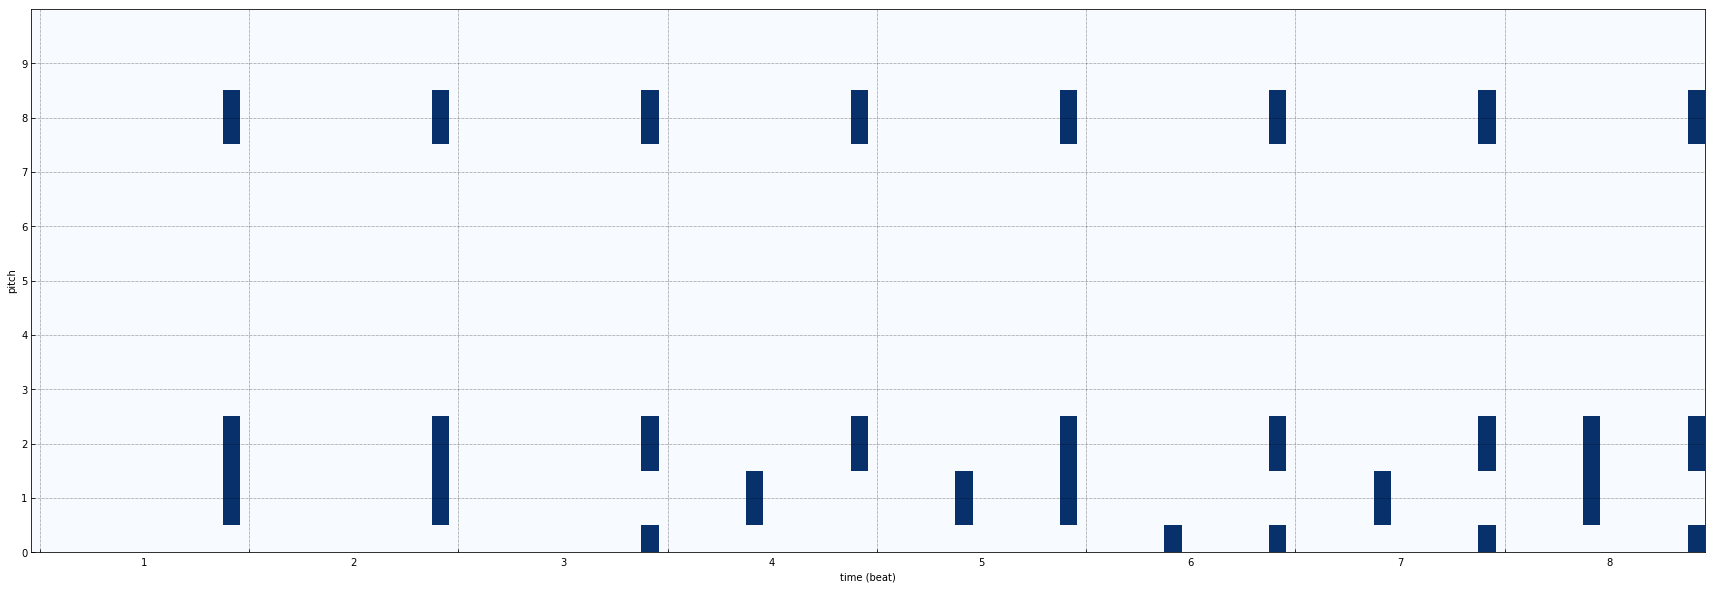

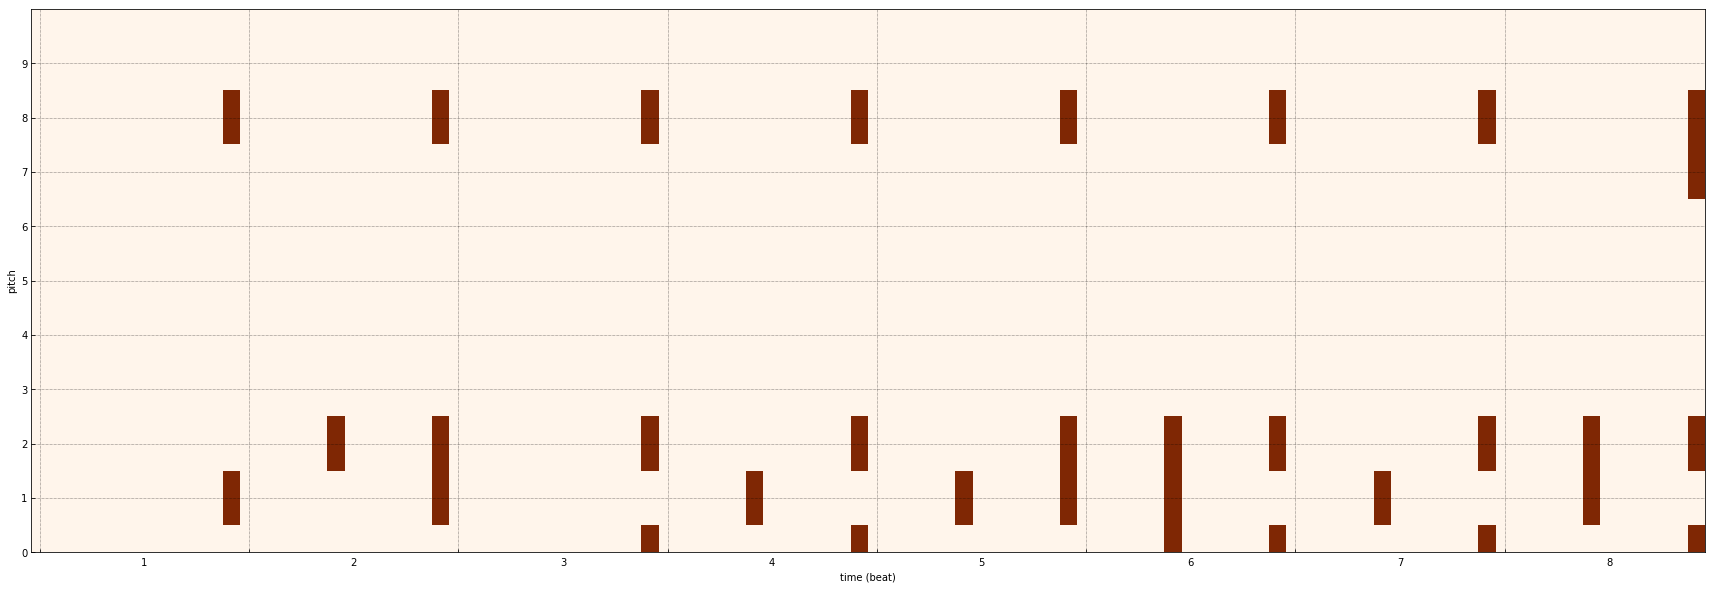

0.99999964 1.373193e-07


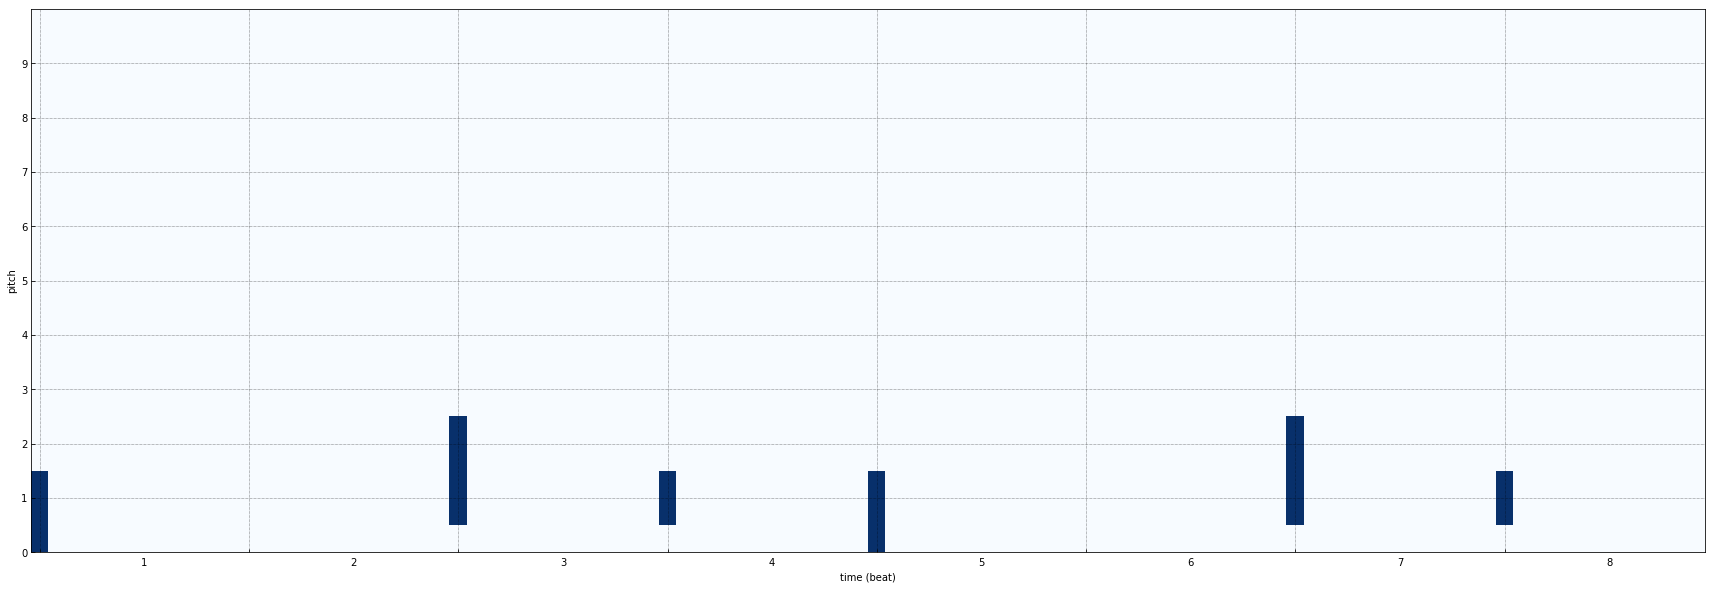

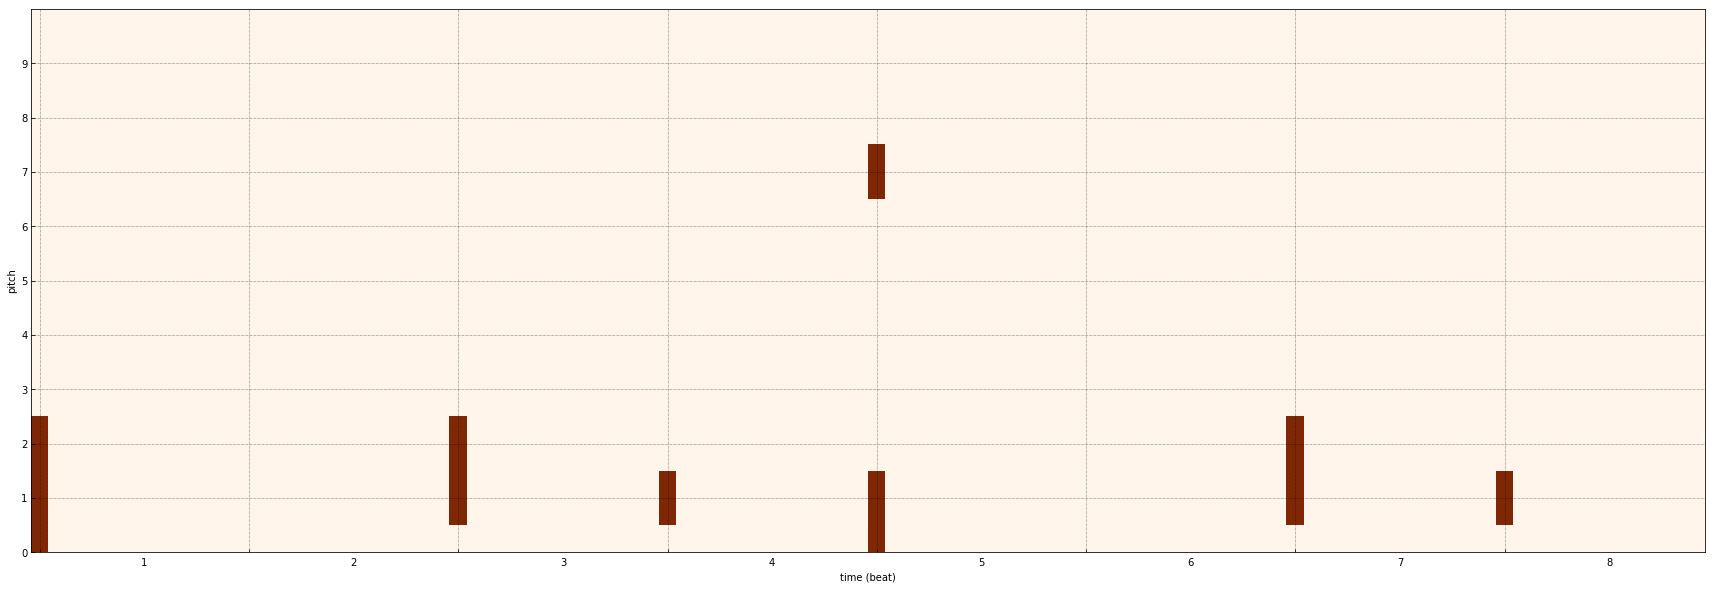

0.9943469 1.06943024e-10


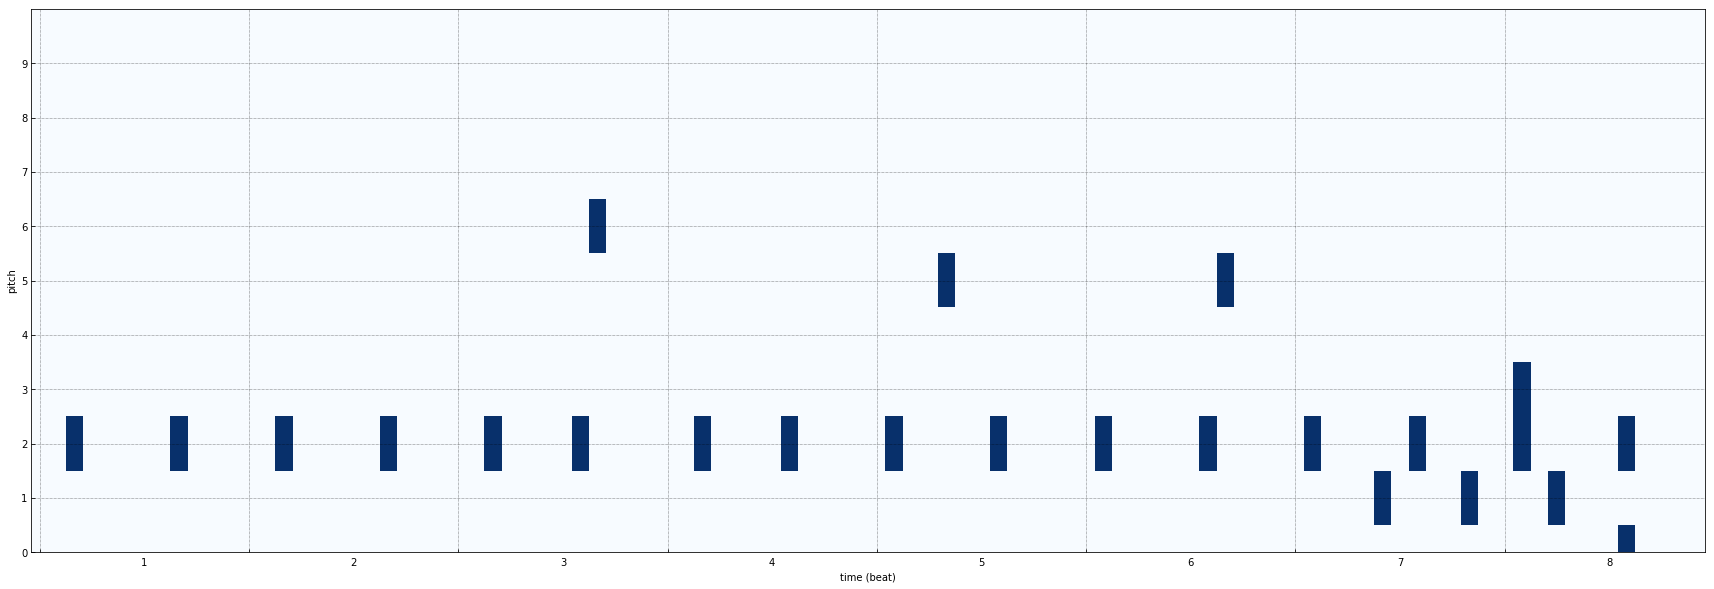

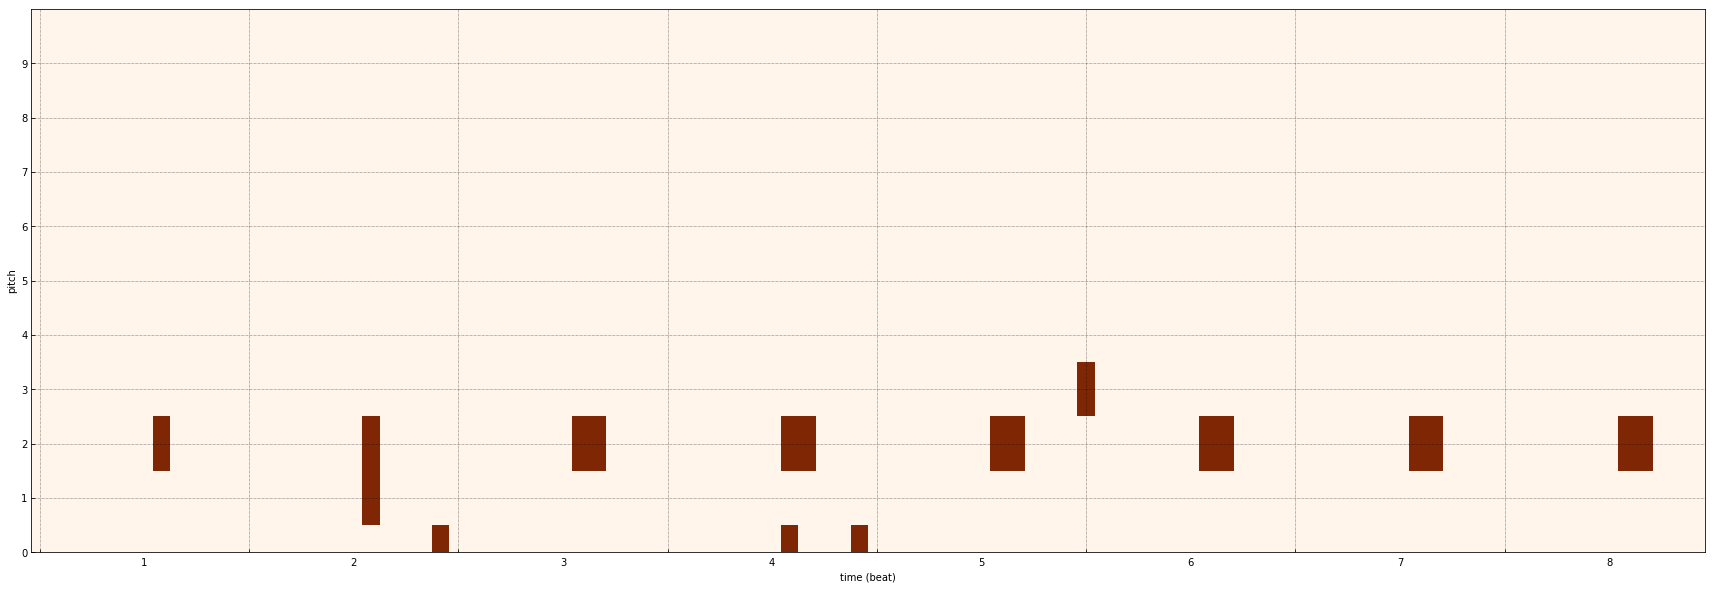

0.98886395 1.1946855e-05


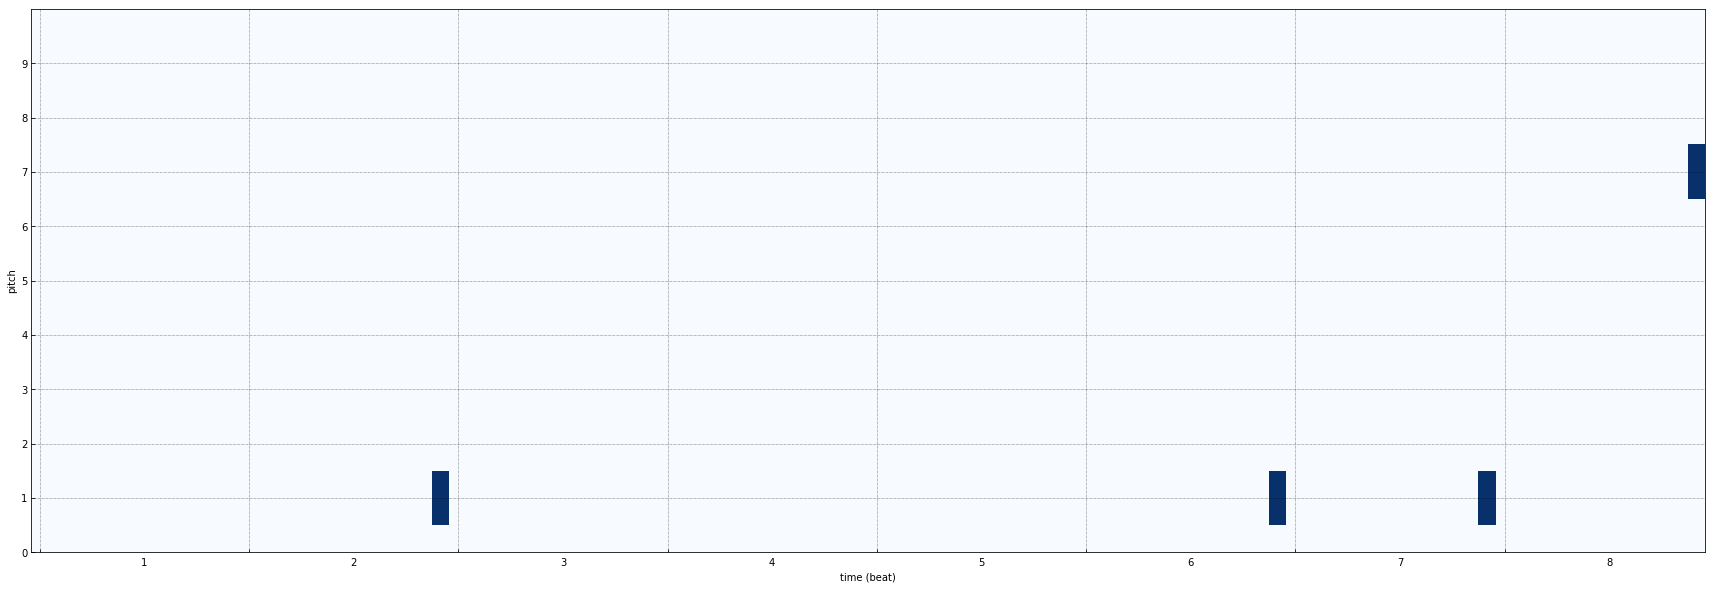

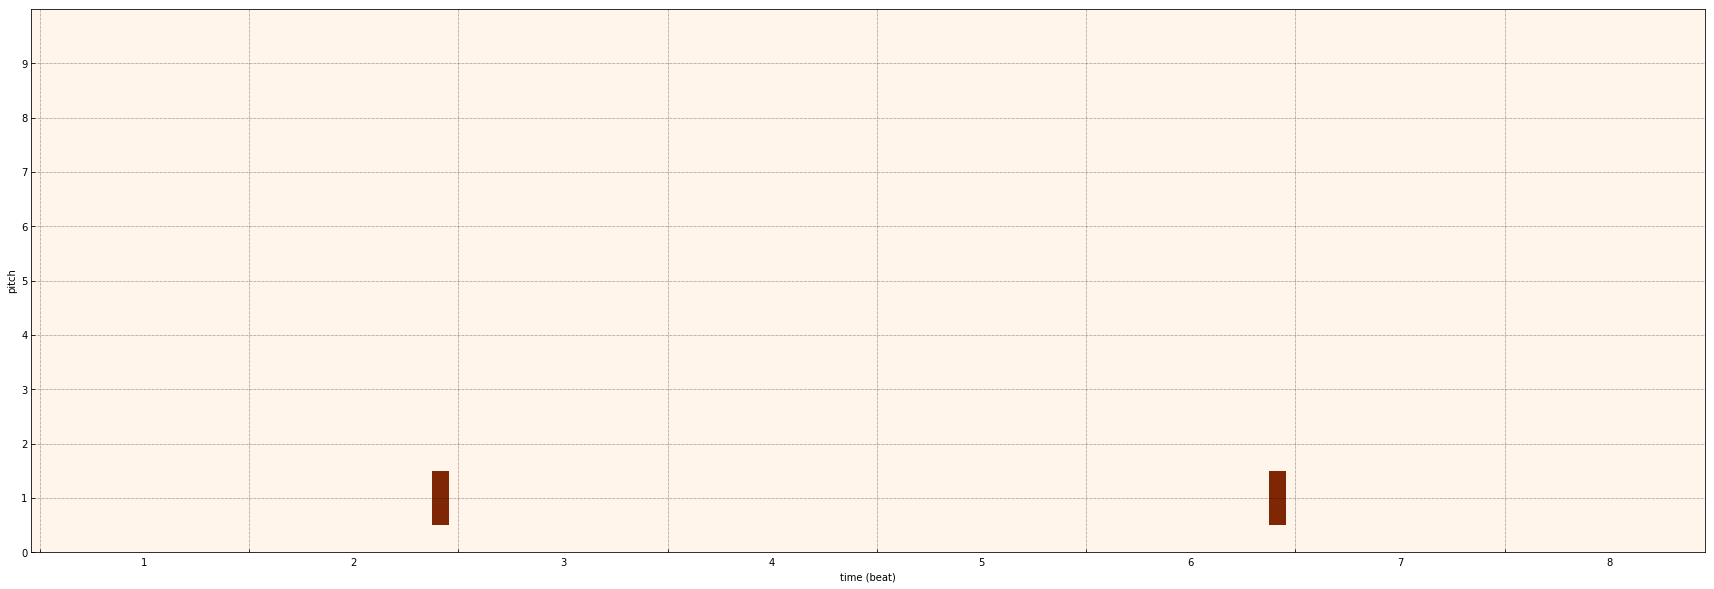

0.99996567 1.1643457e-06


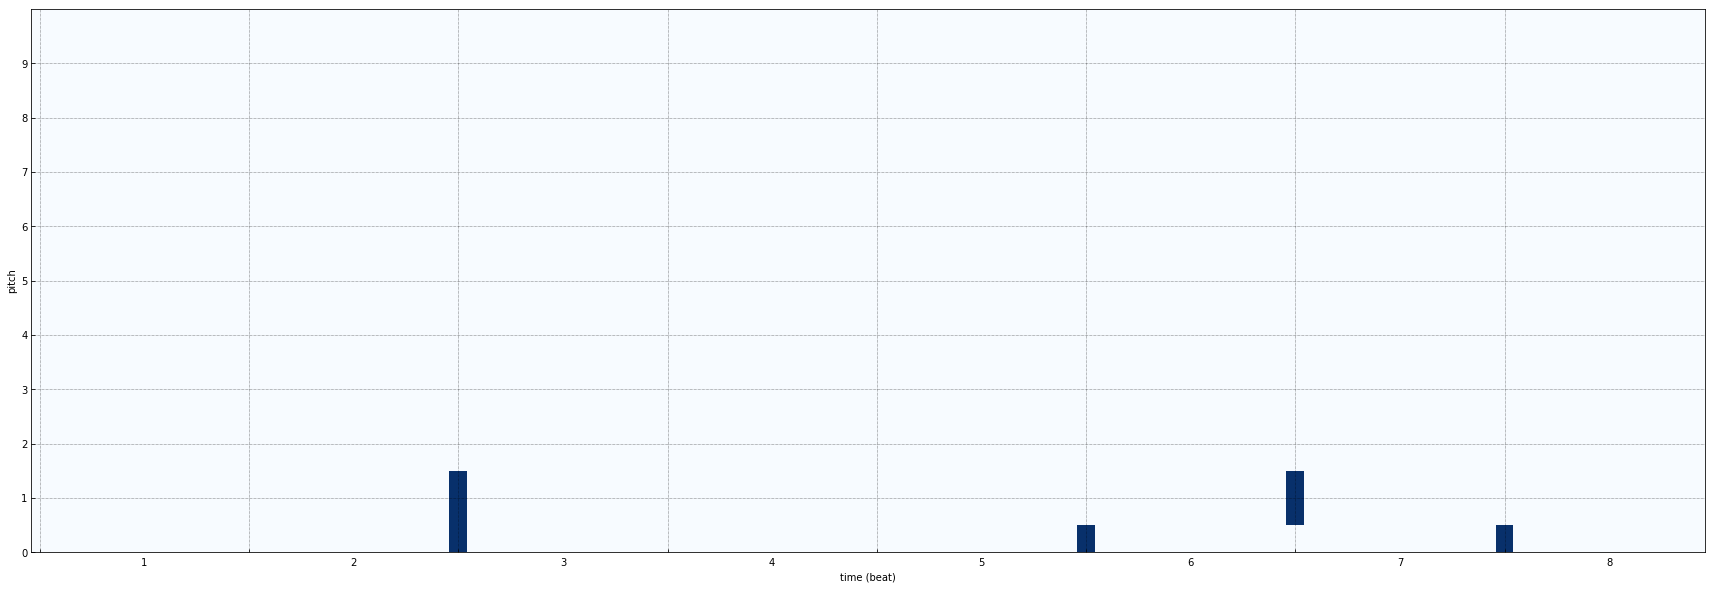

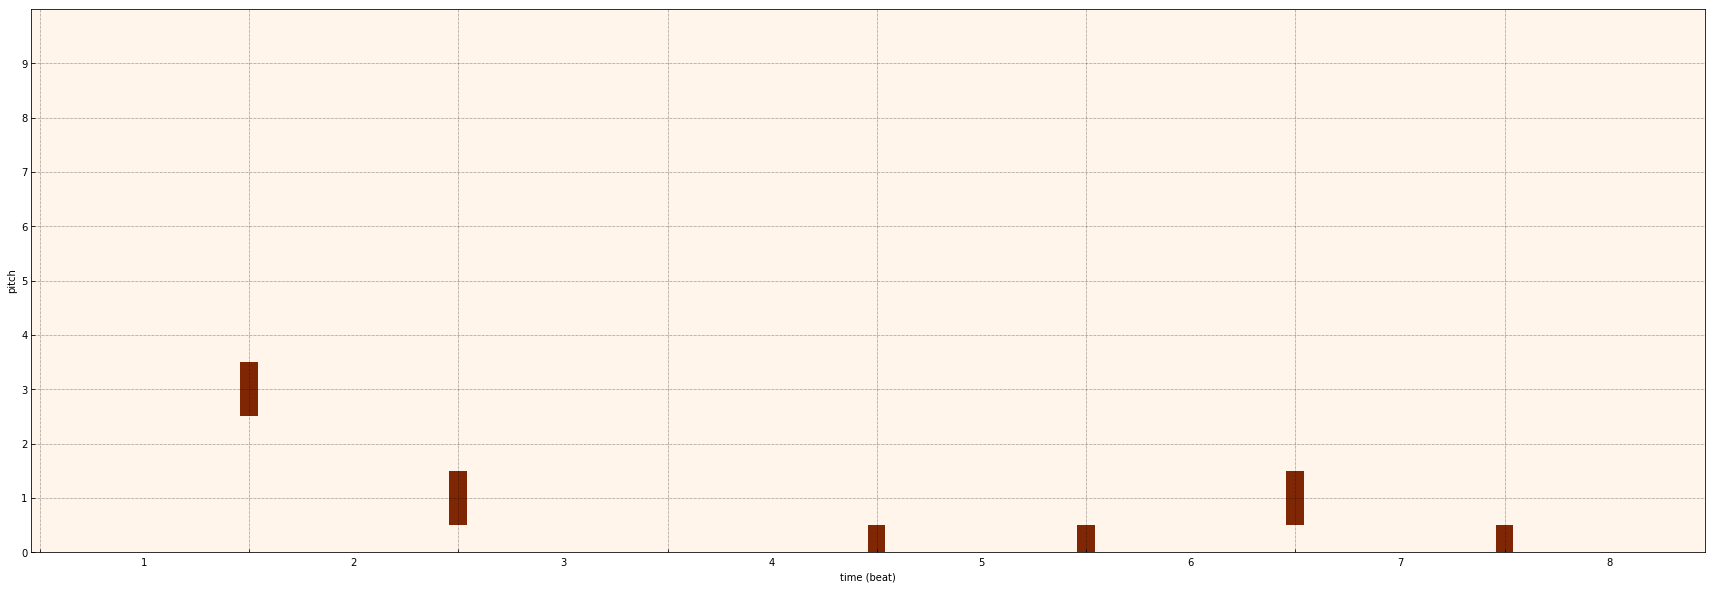

1.0 6.7777906e-10


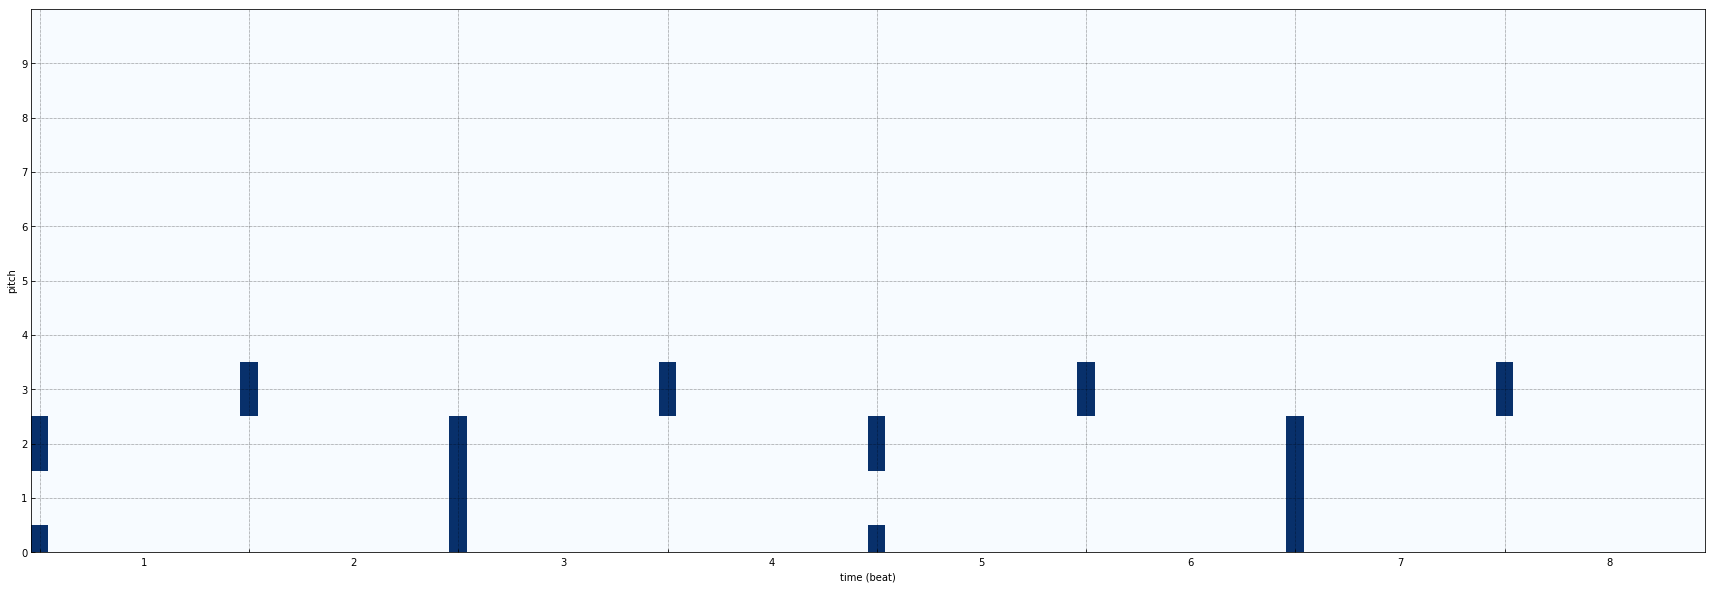

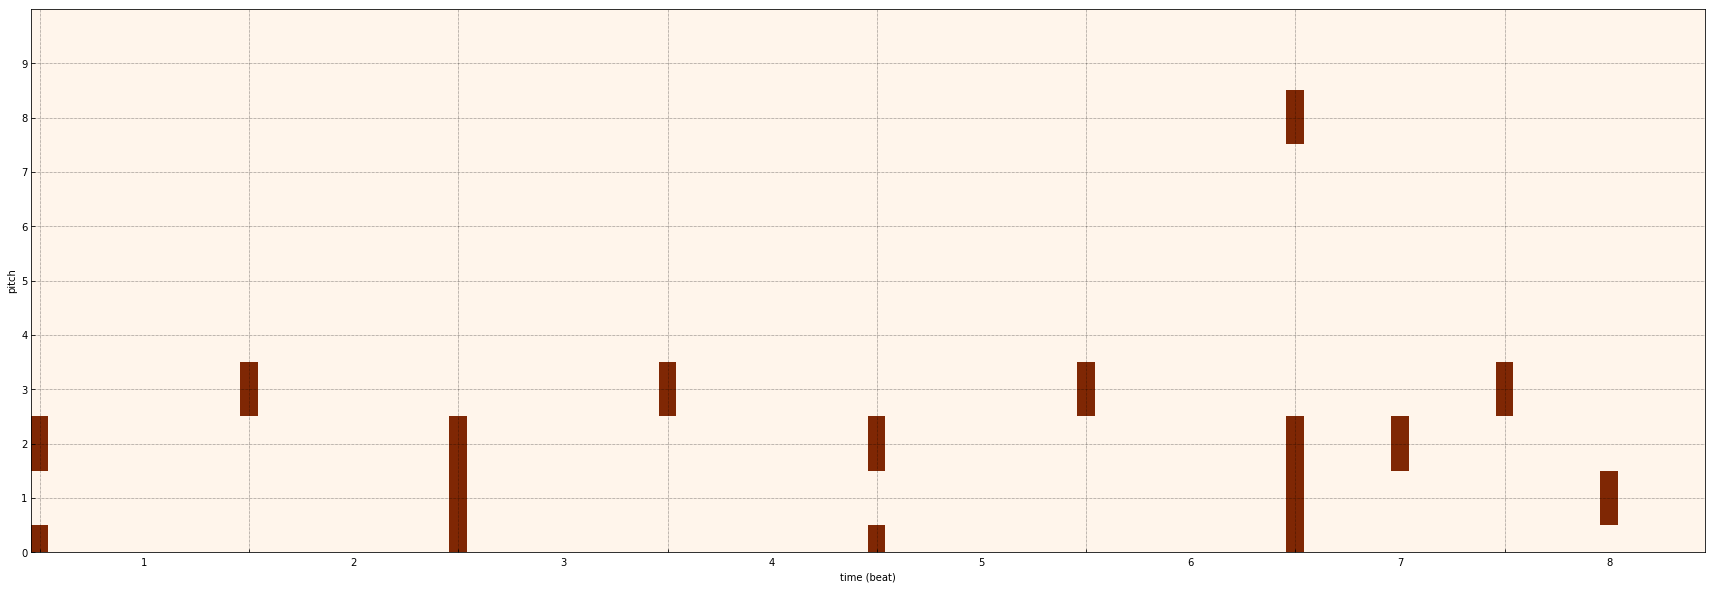

0.2545417 2.7673433e-10


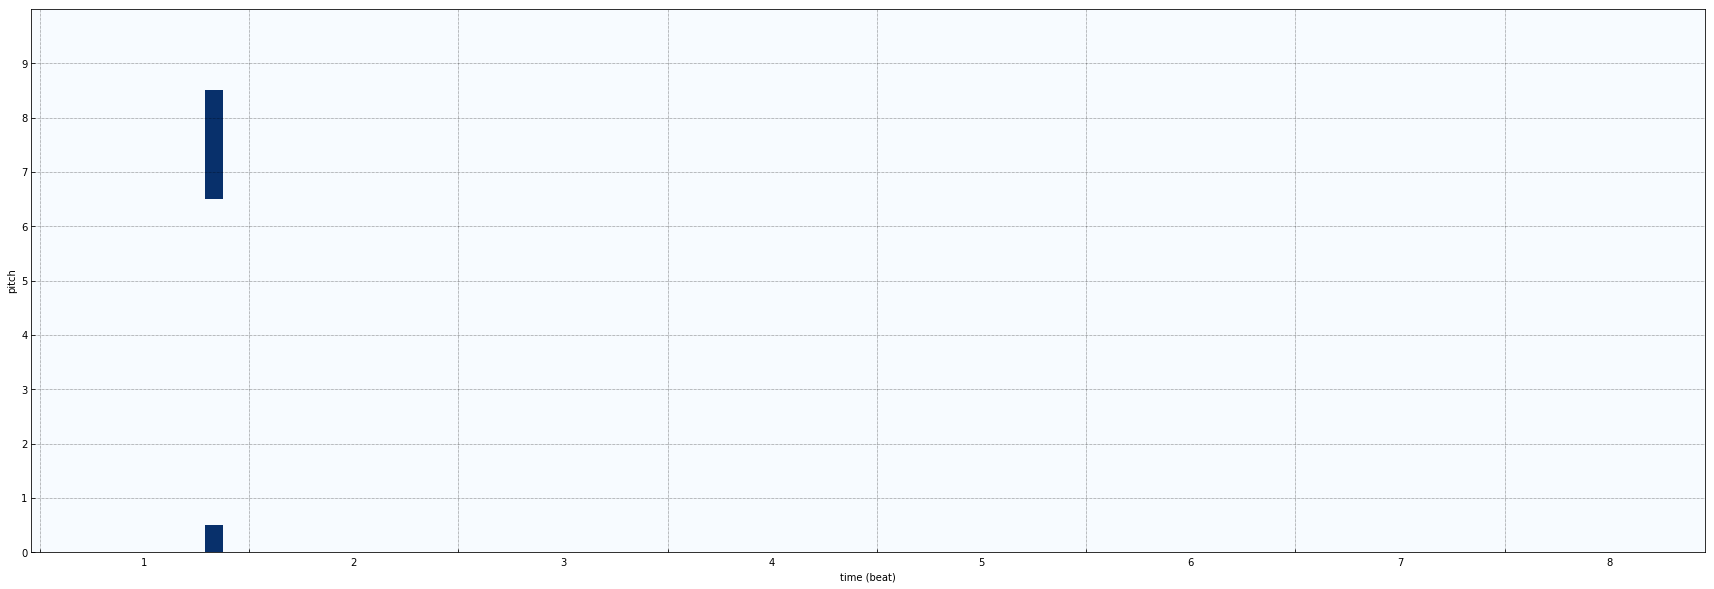

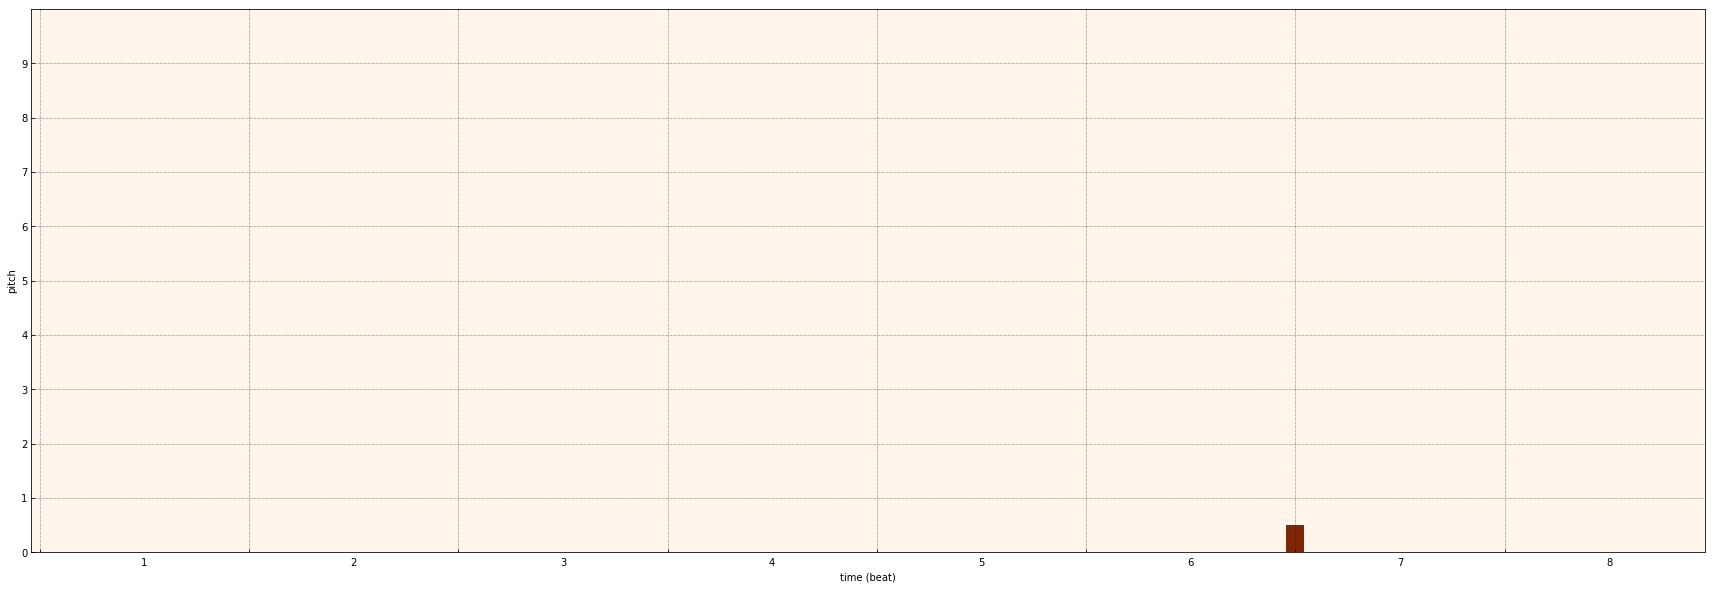

0.9999982 9.908163e-09


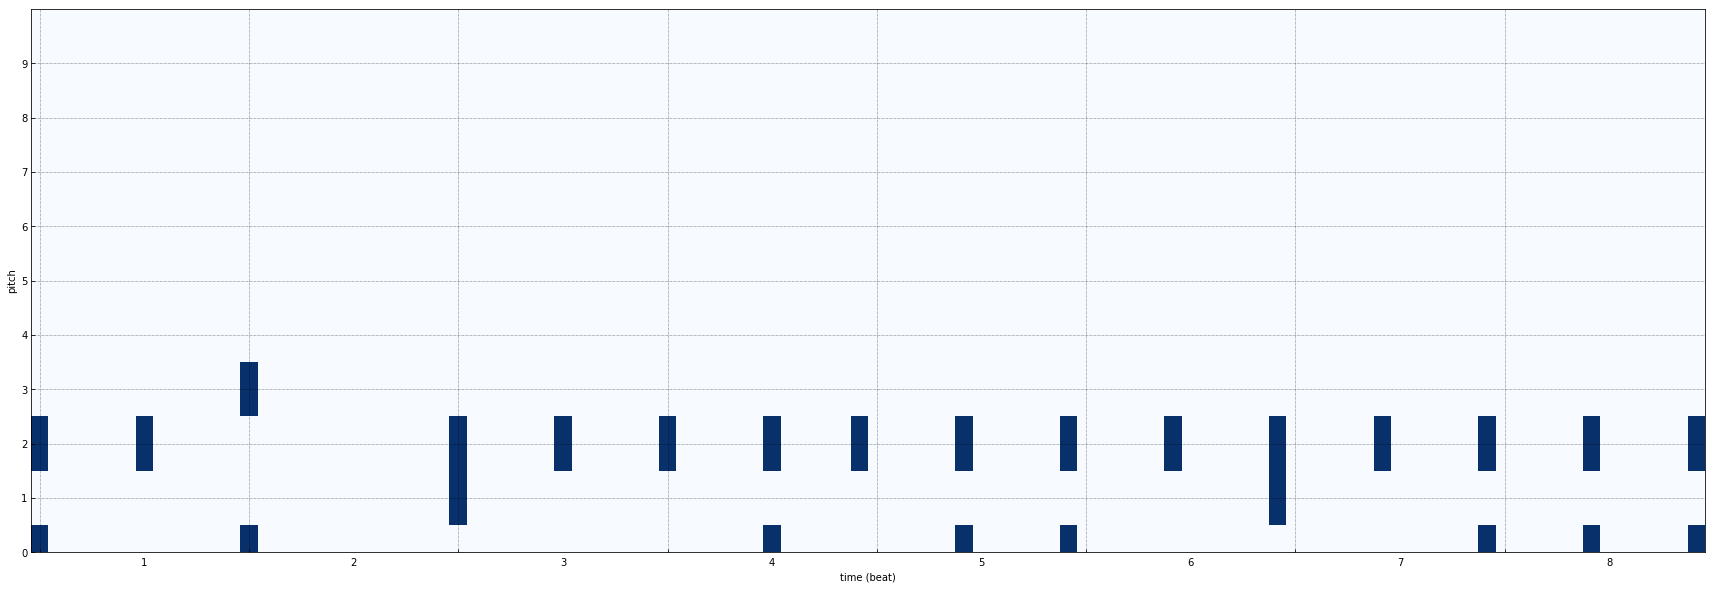

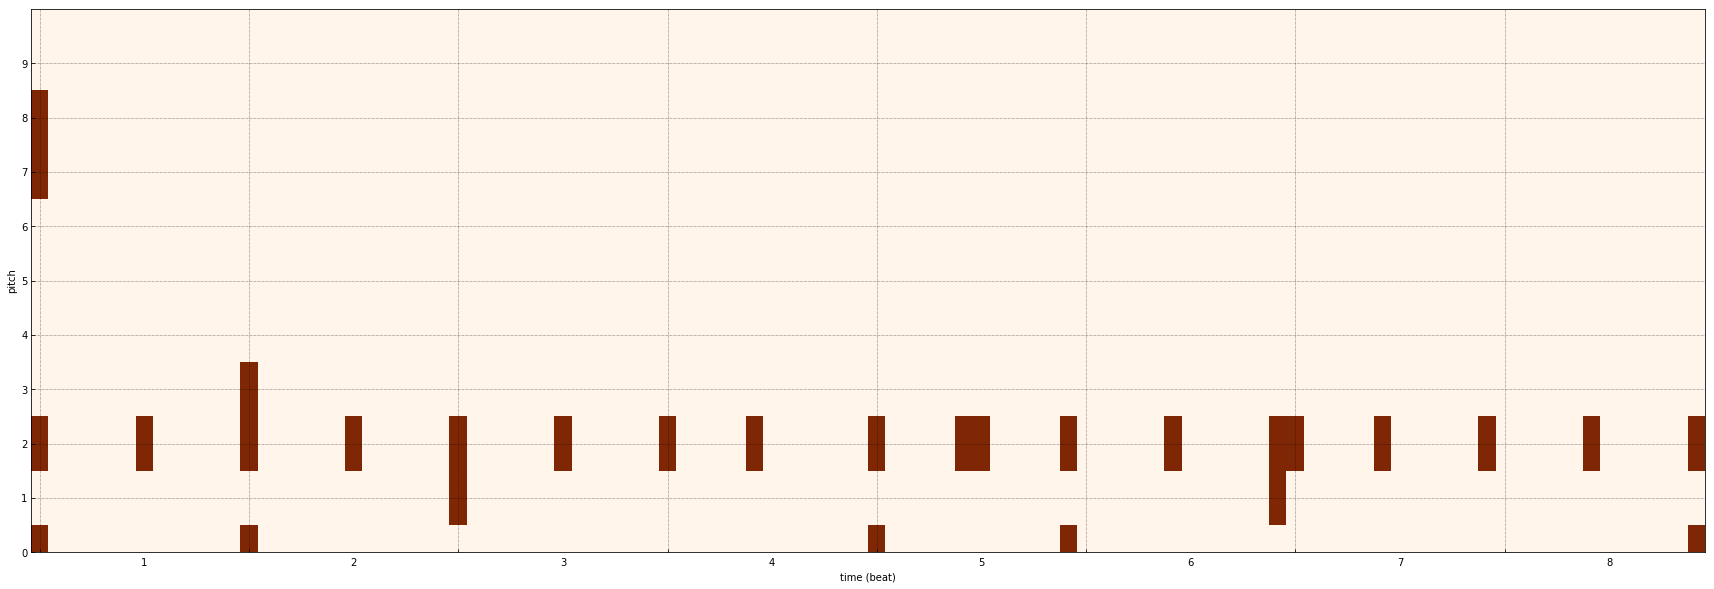

1.0 1.0163288e-06


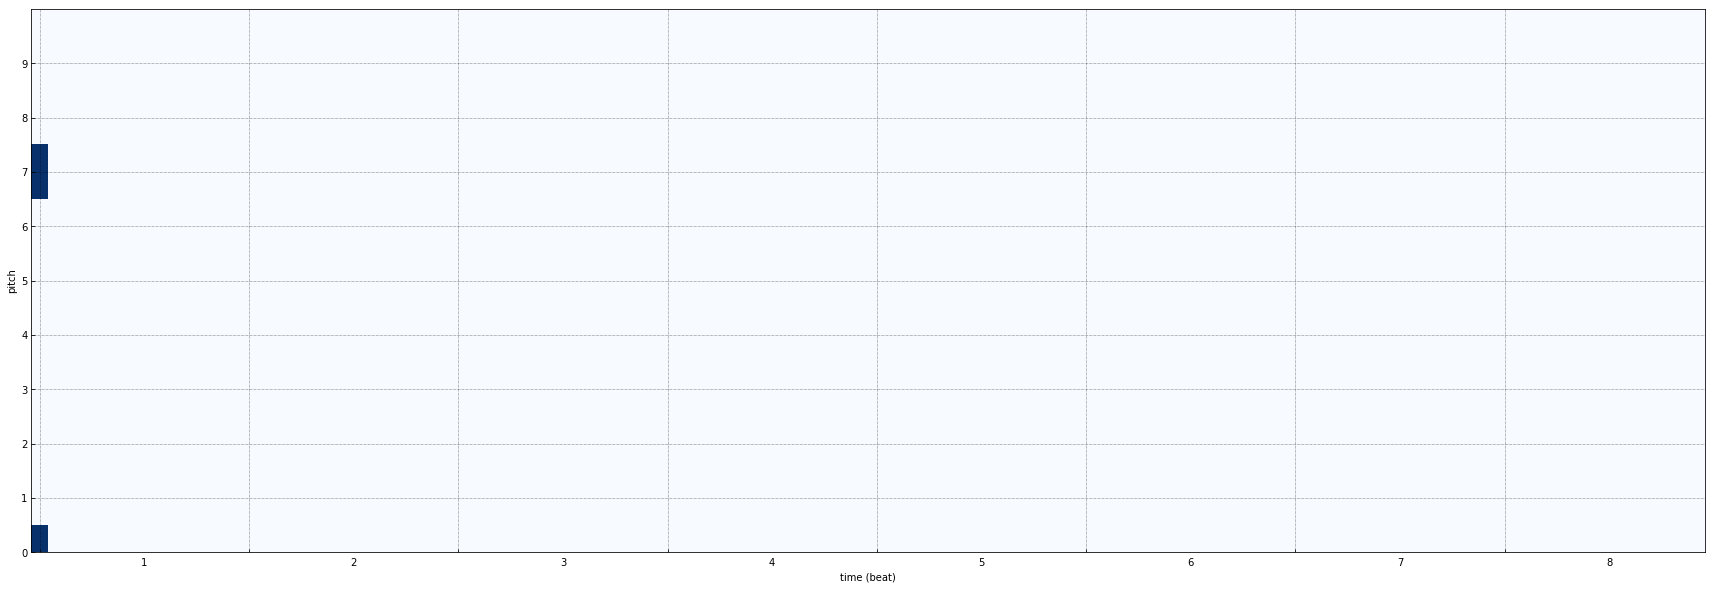

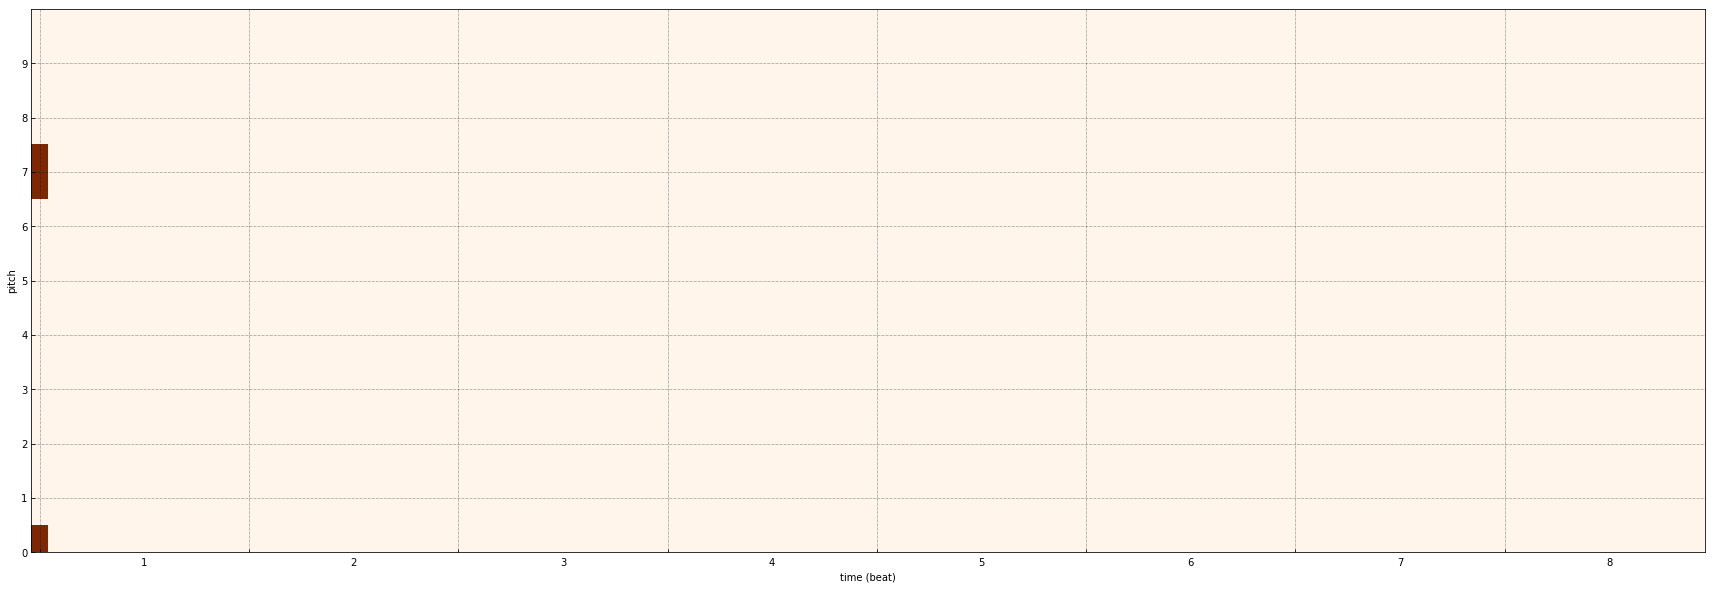

0.9994979 6.140431e-09


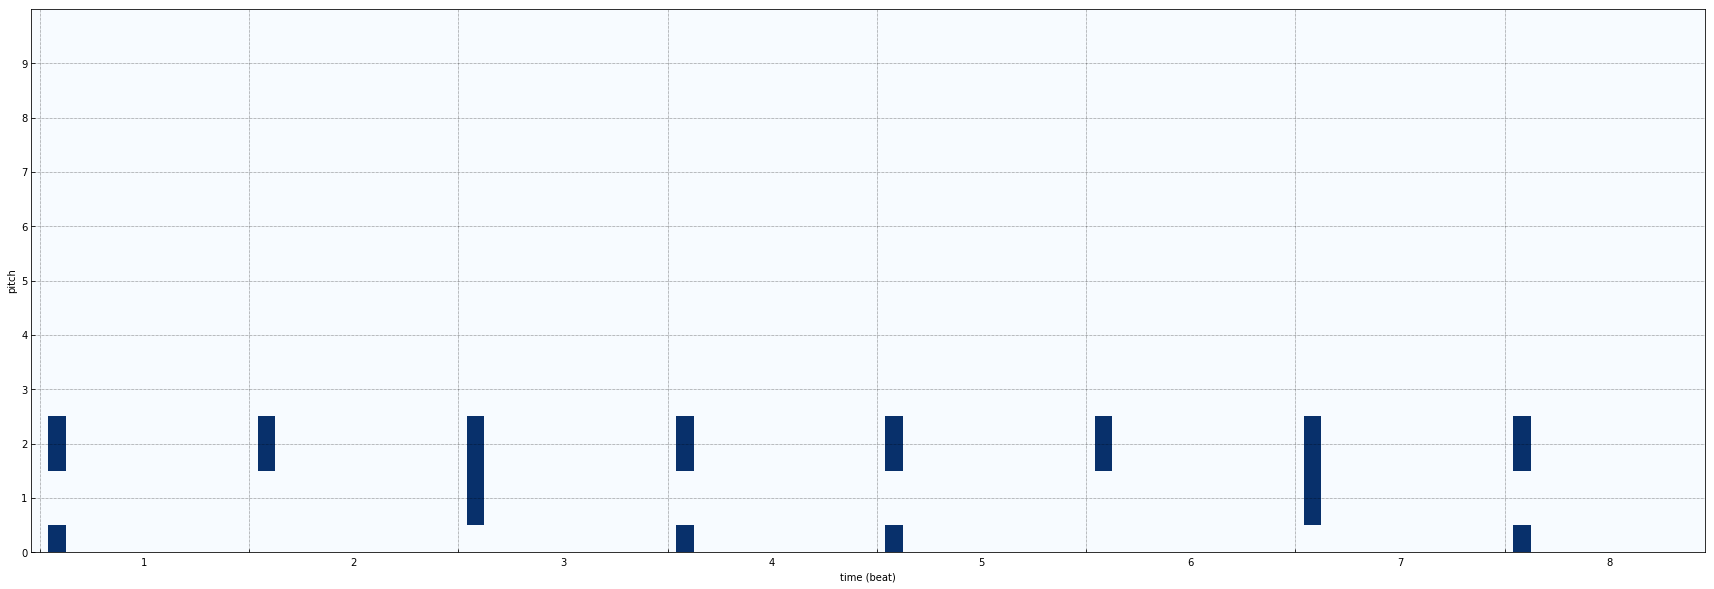

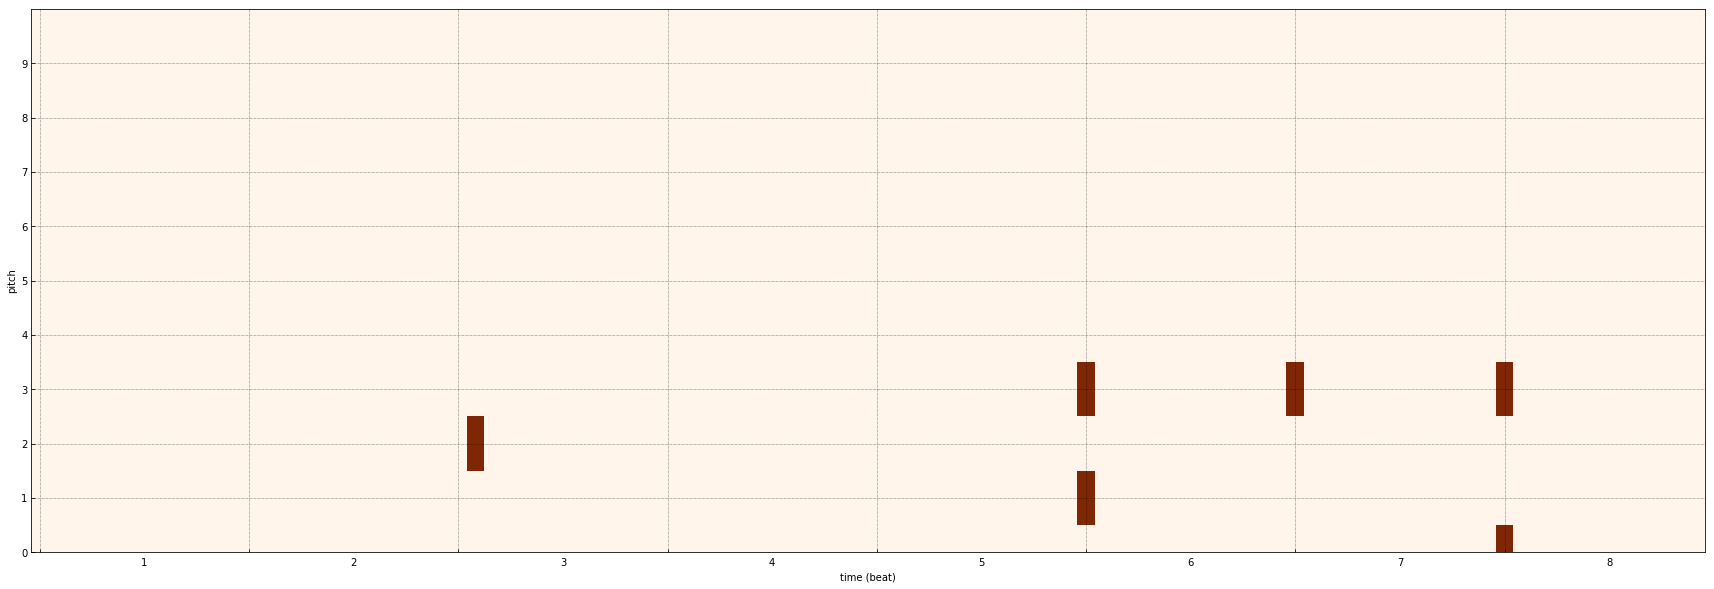

0.9999865 1.2210678e-06


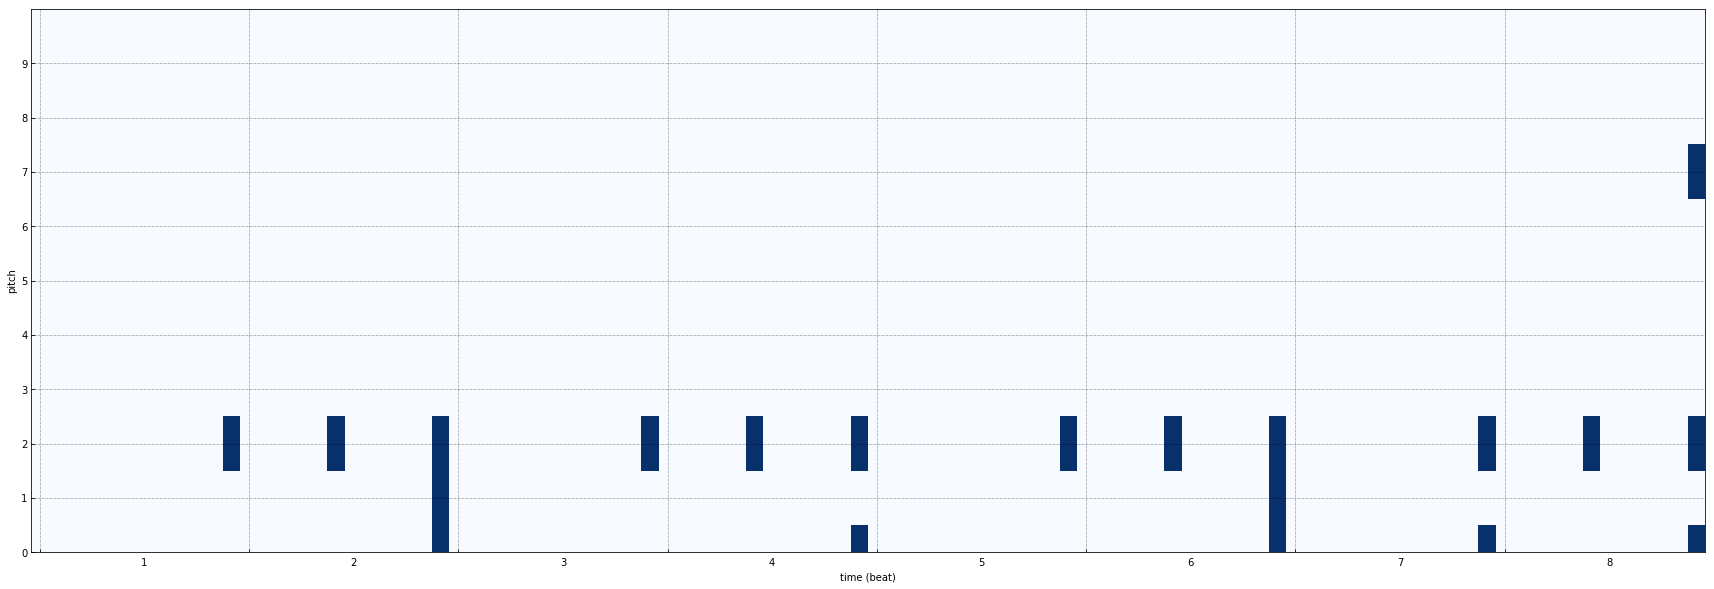

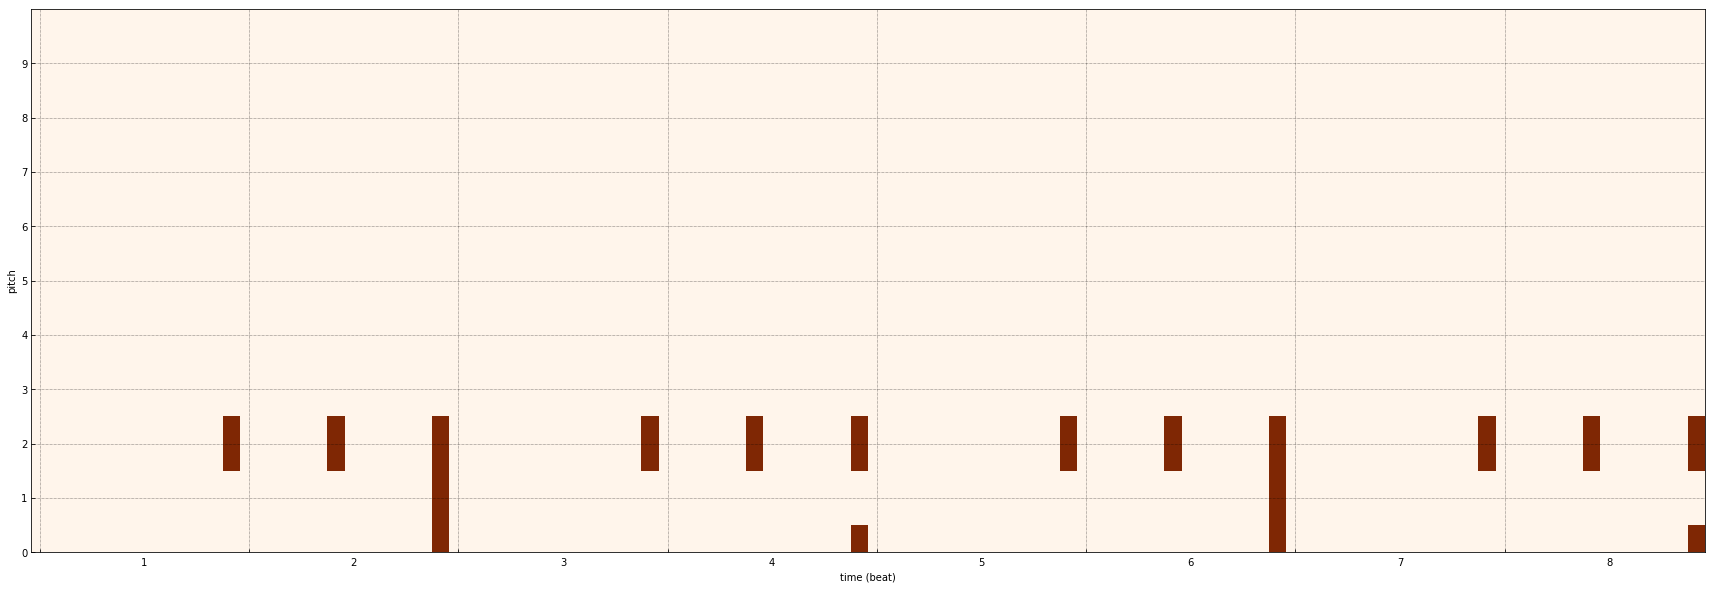

0.9999224 8.434266e-07


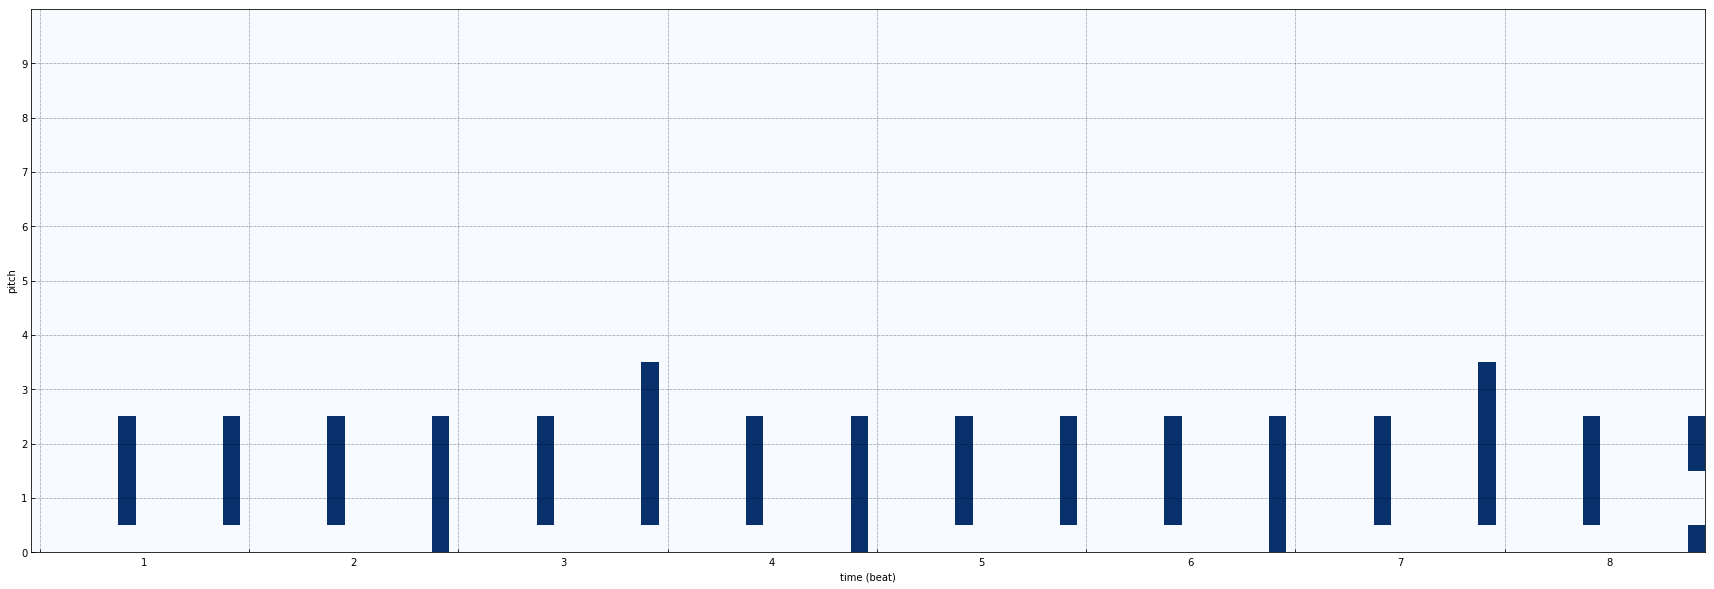

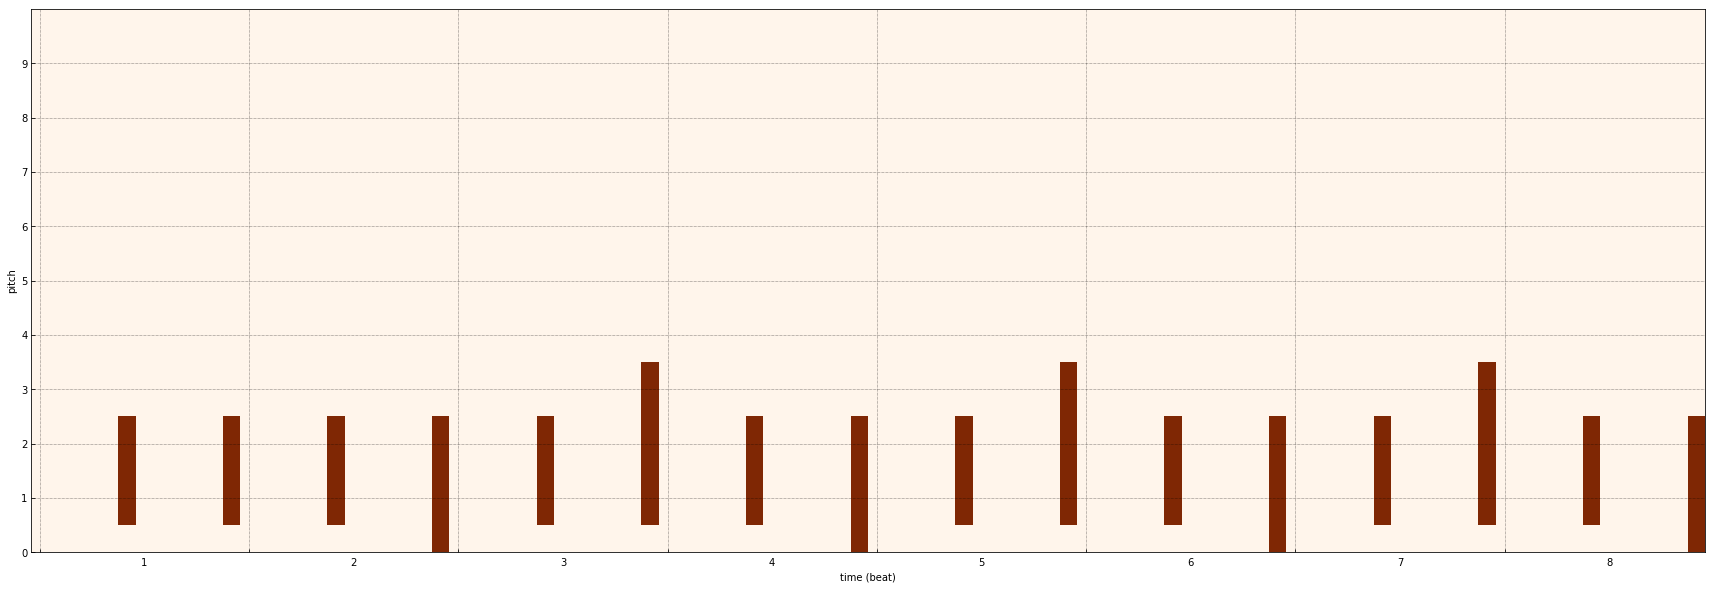

1.0 1.8086641e-07


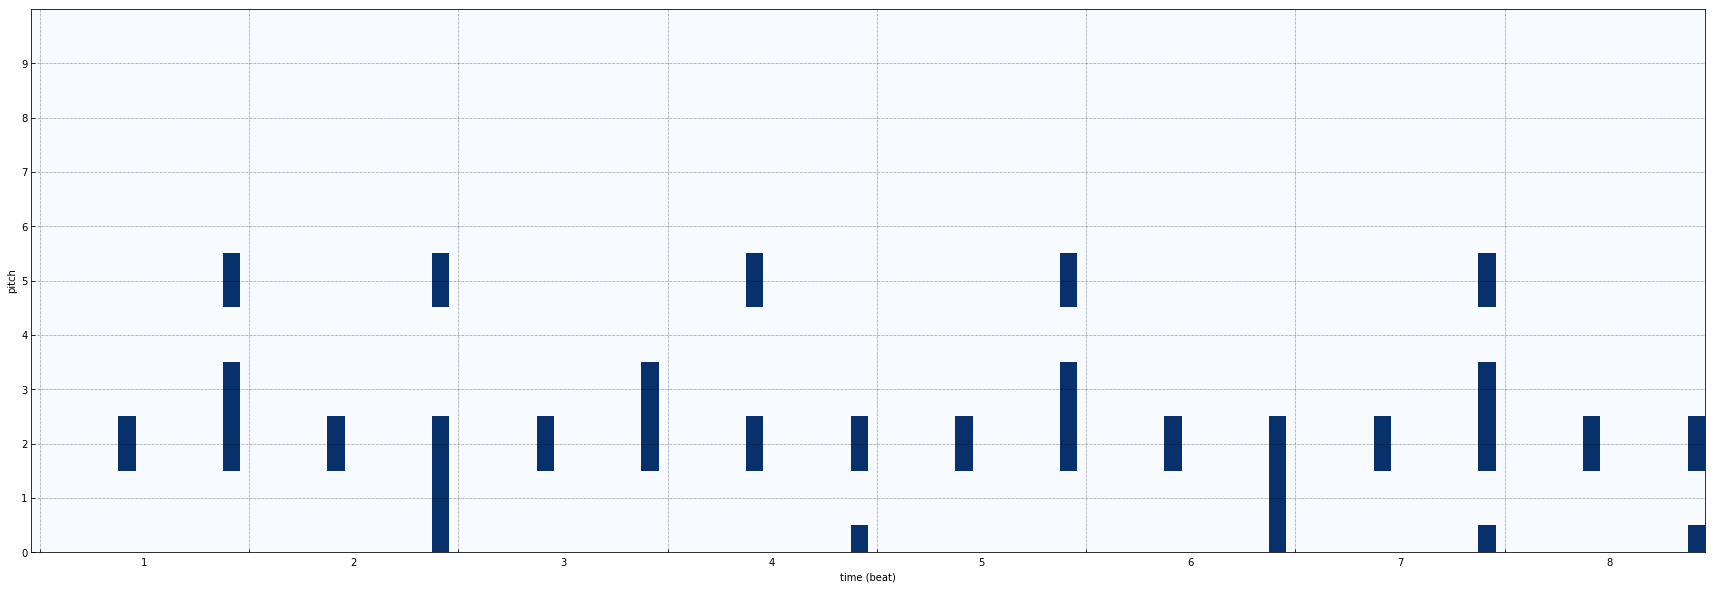

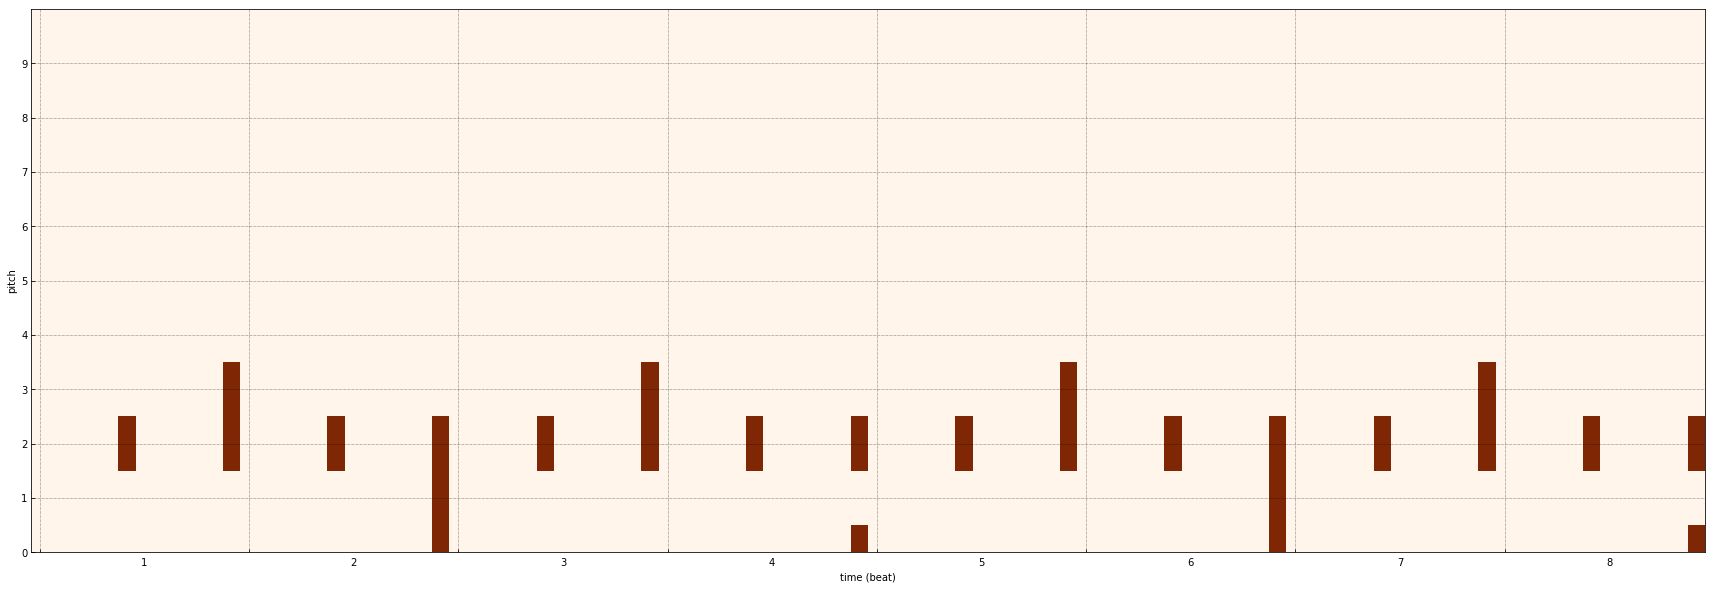

0.99999464 1.2765073e-06


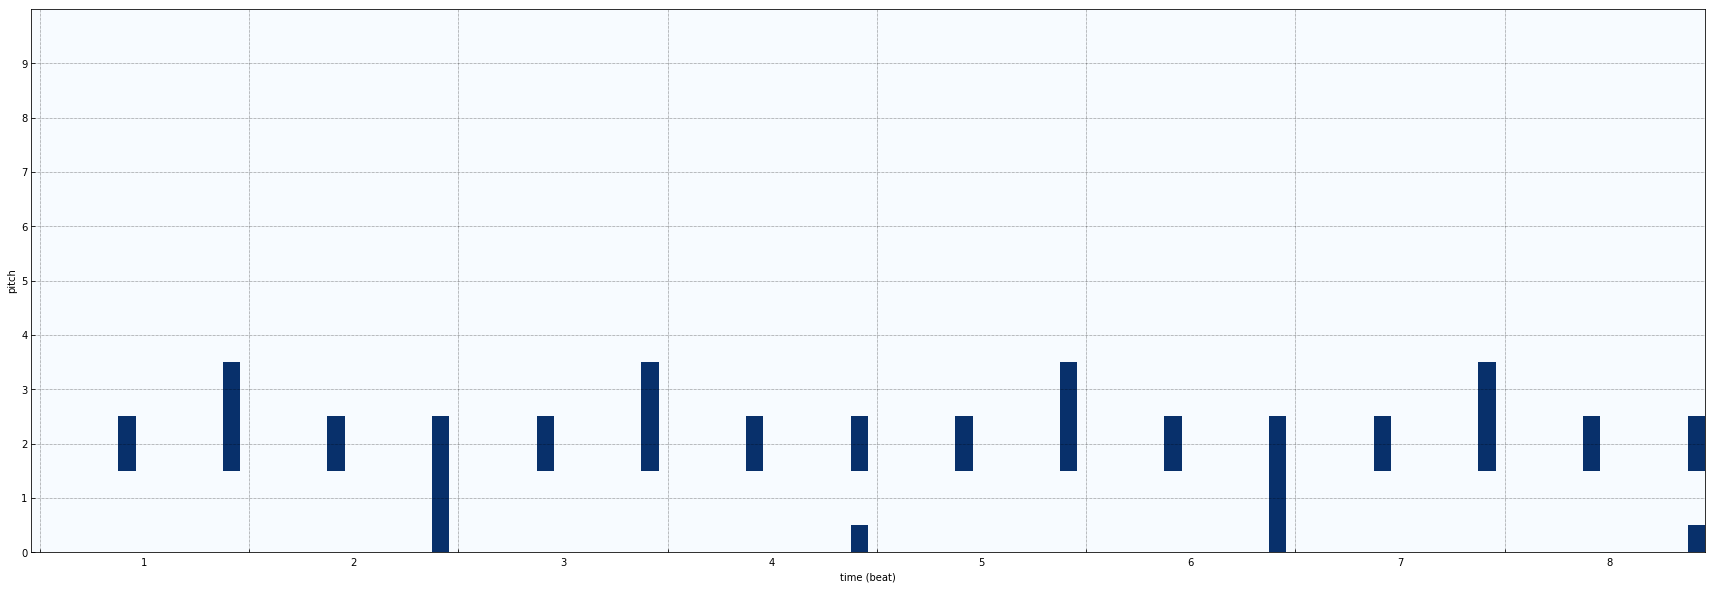

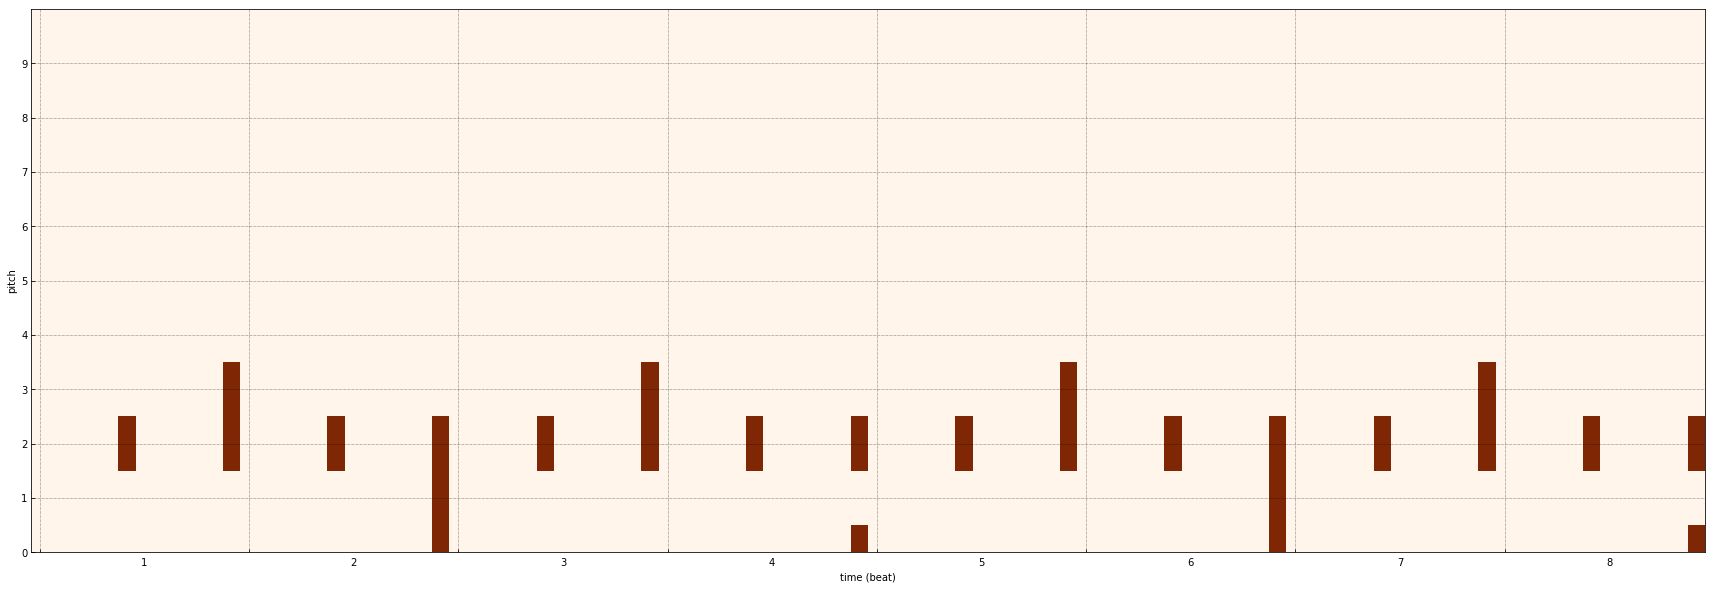

0.9986029 5.617416e-08


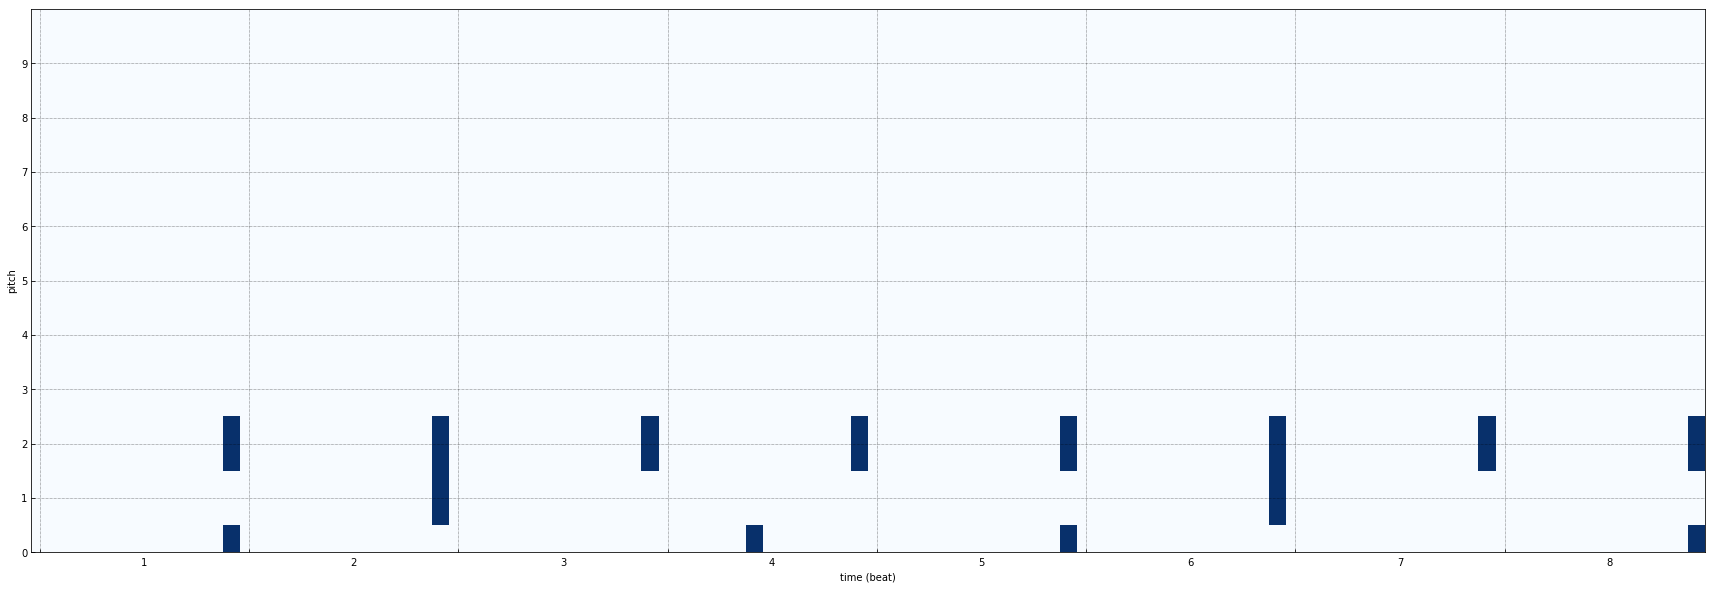

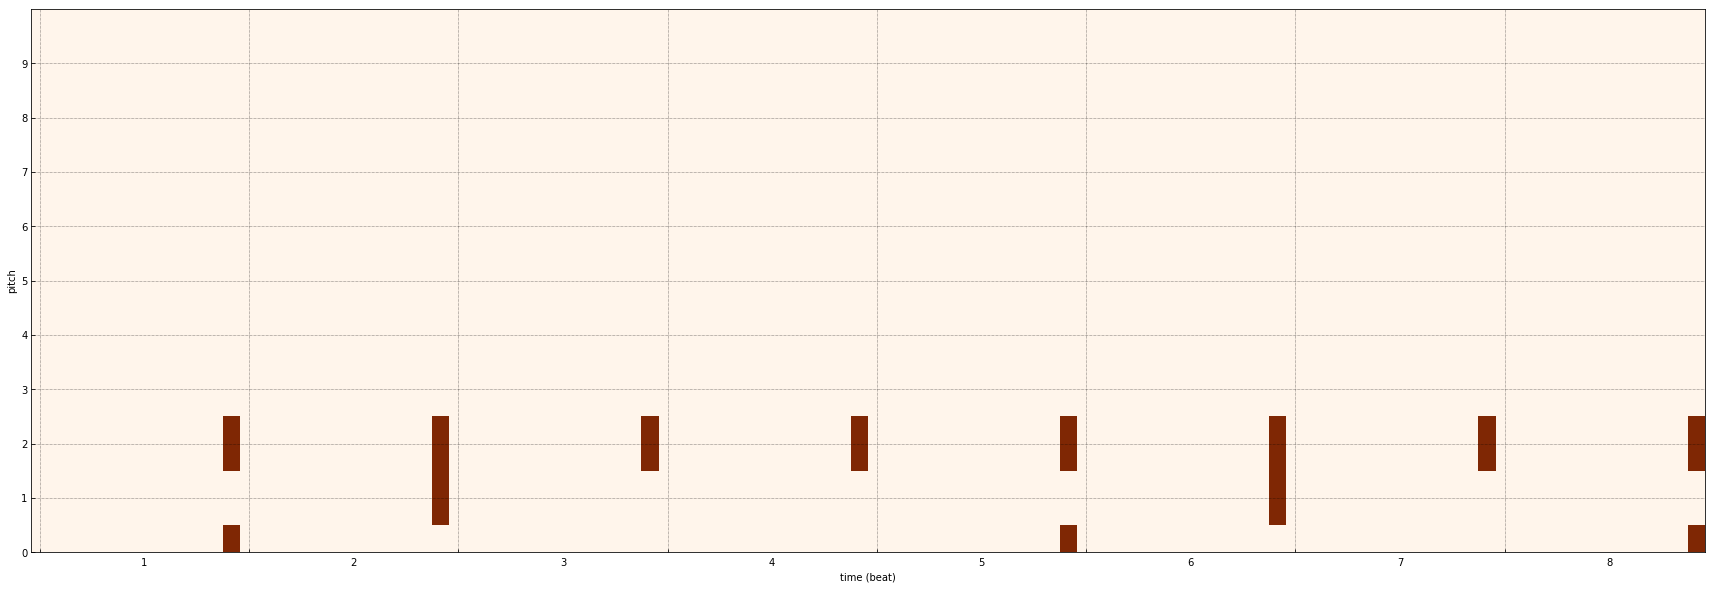

1.0 1.2232732e-08


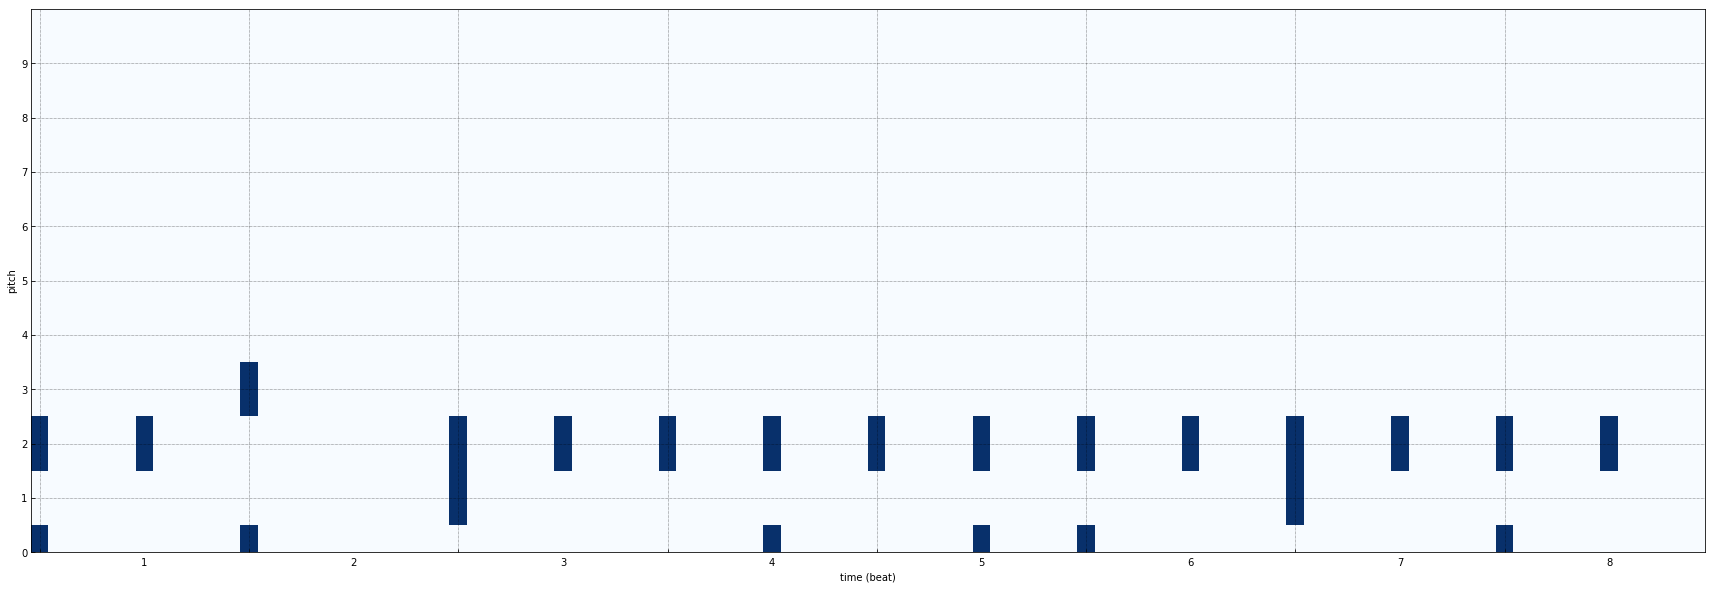

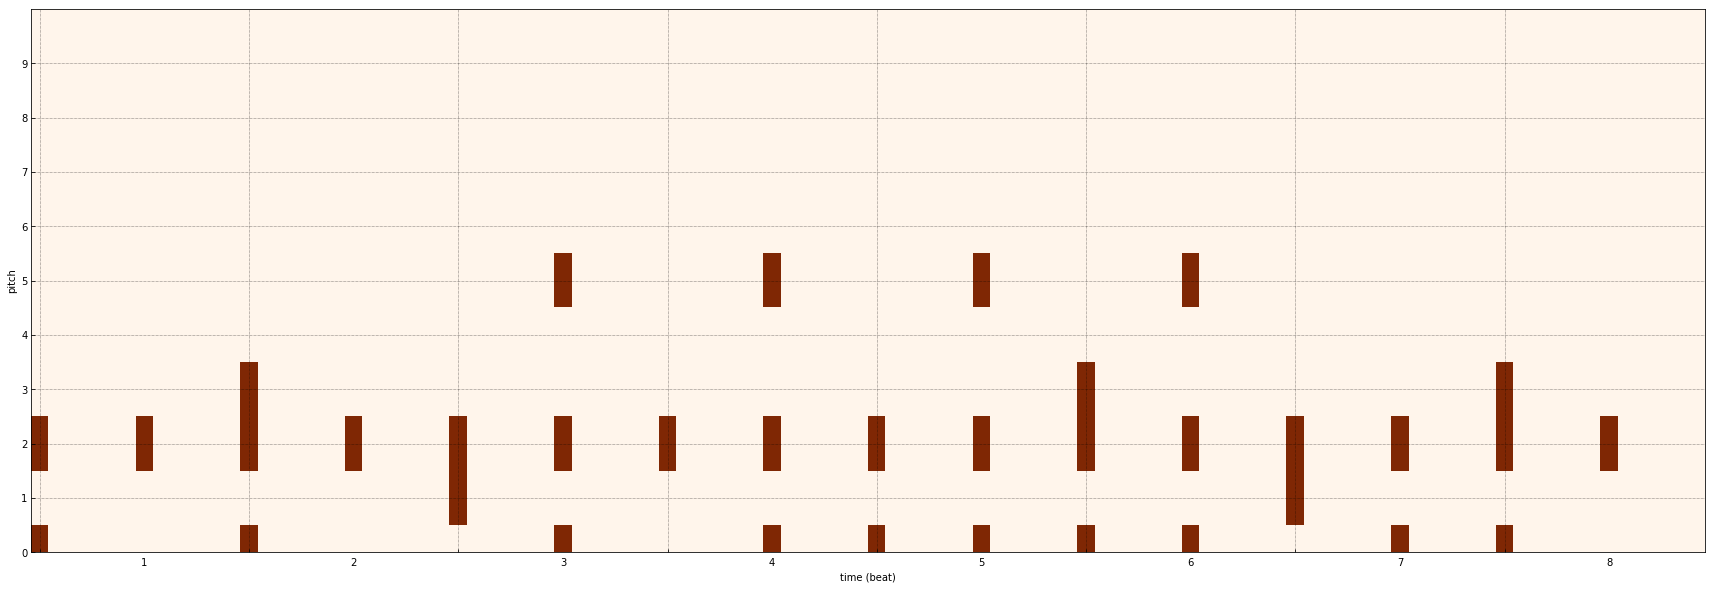

0.99999607 2.4140175e-07


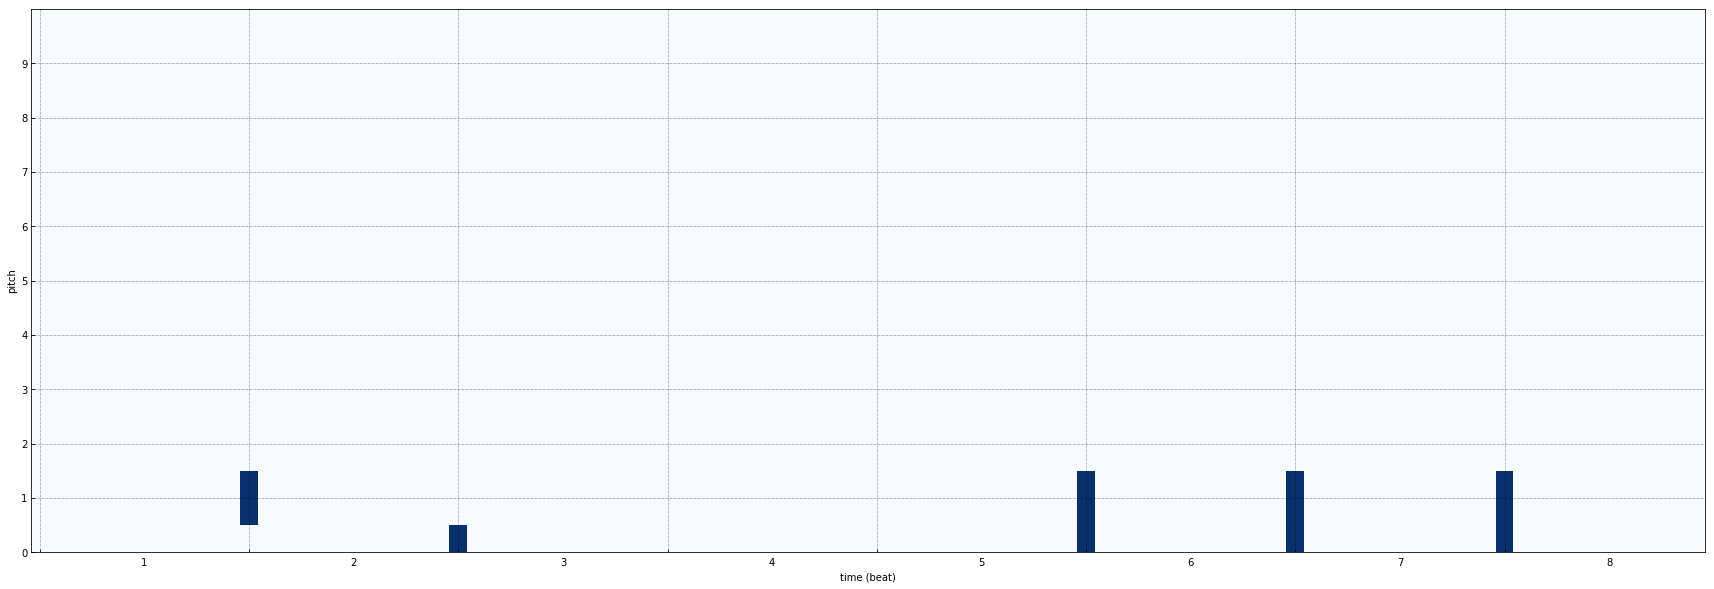

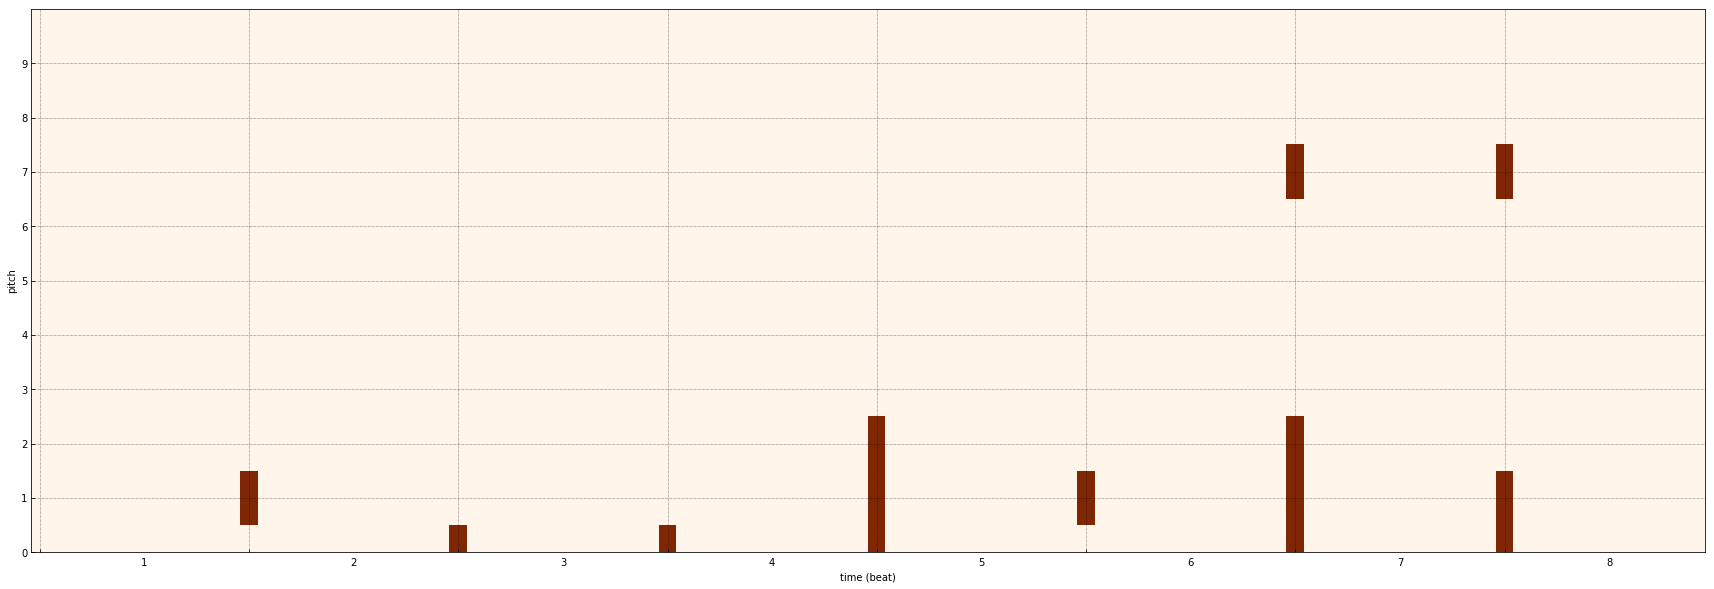

0.99997866 5.038969e-07


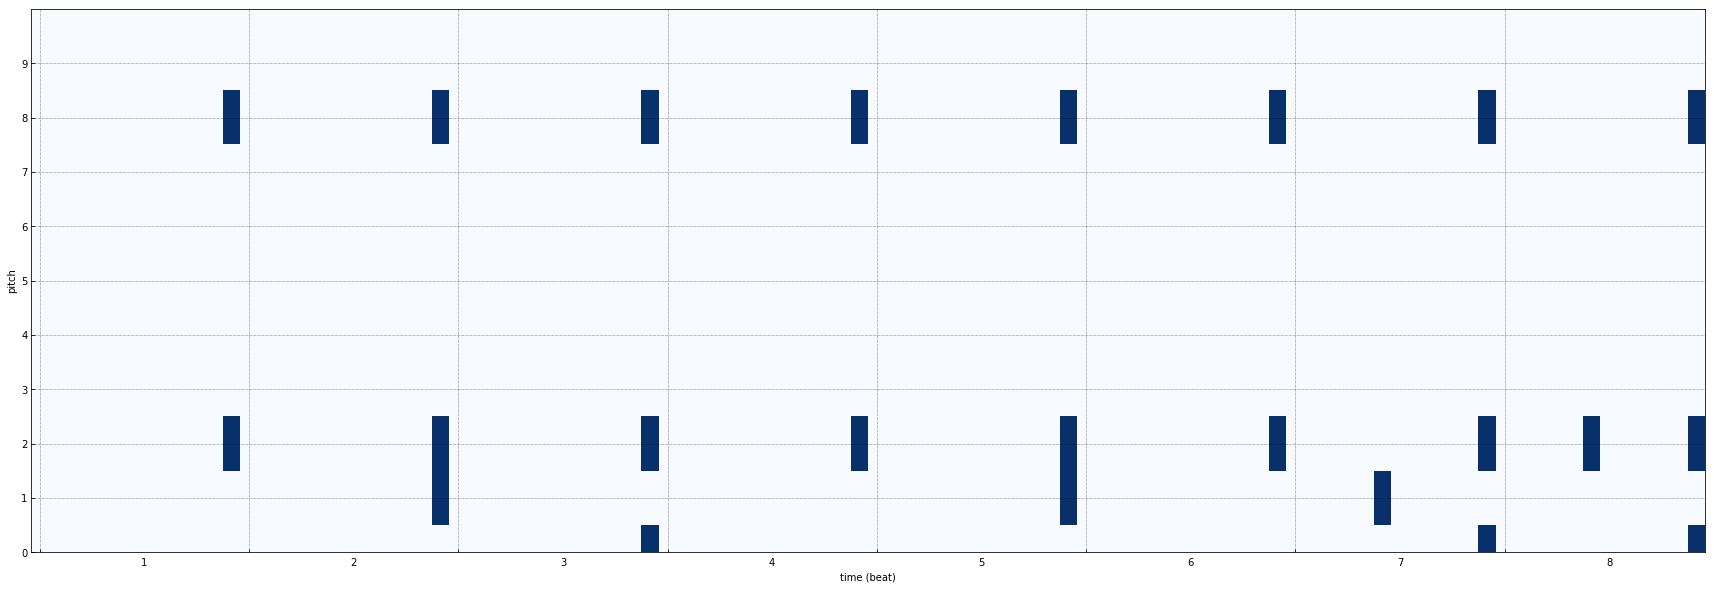

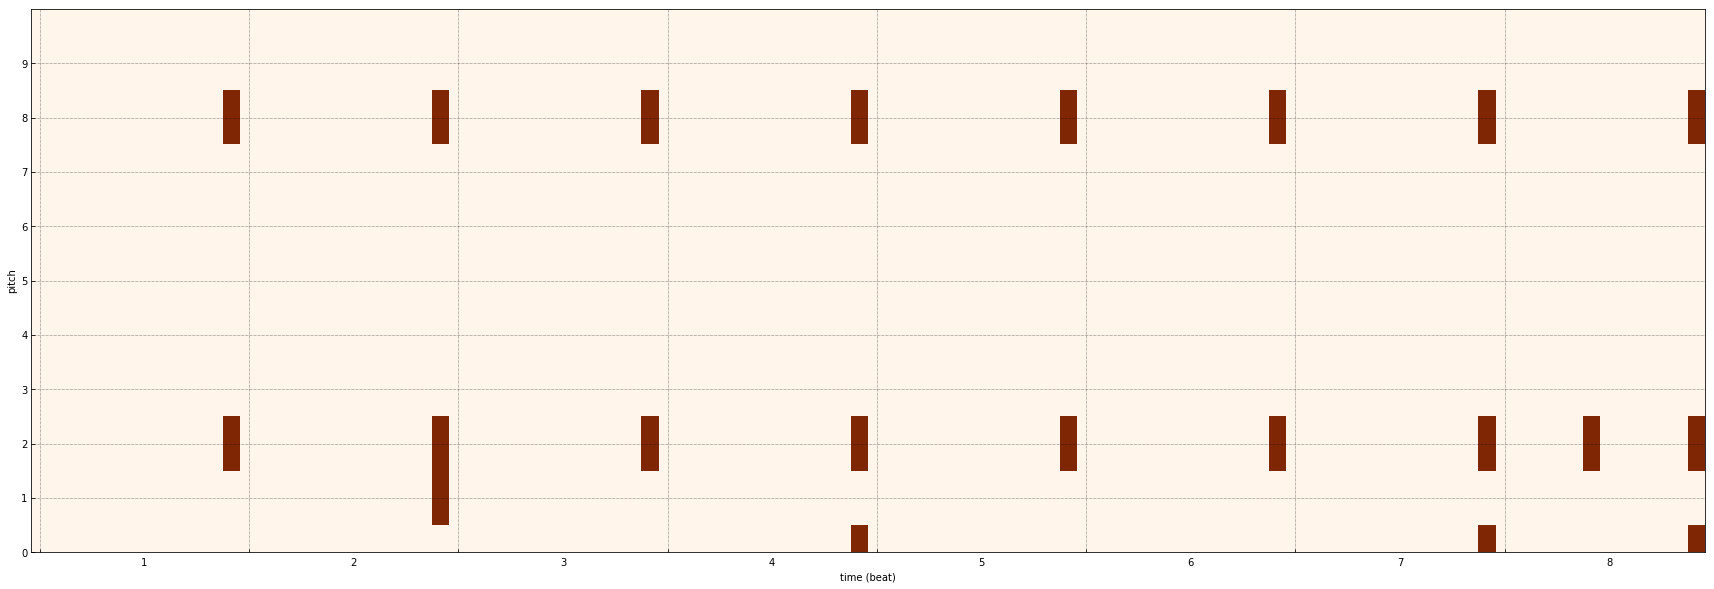

0.98257947 1.3575336e-08


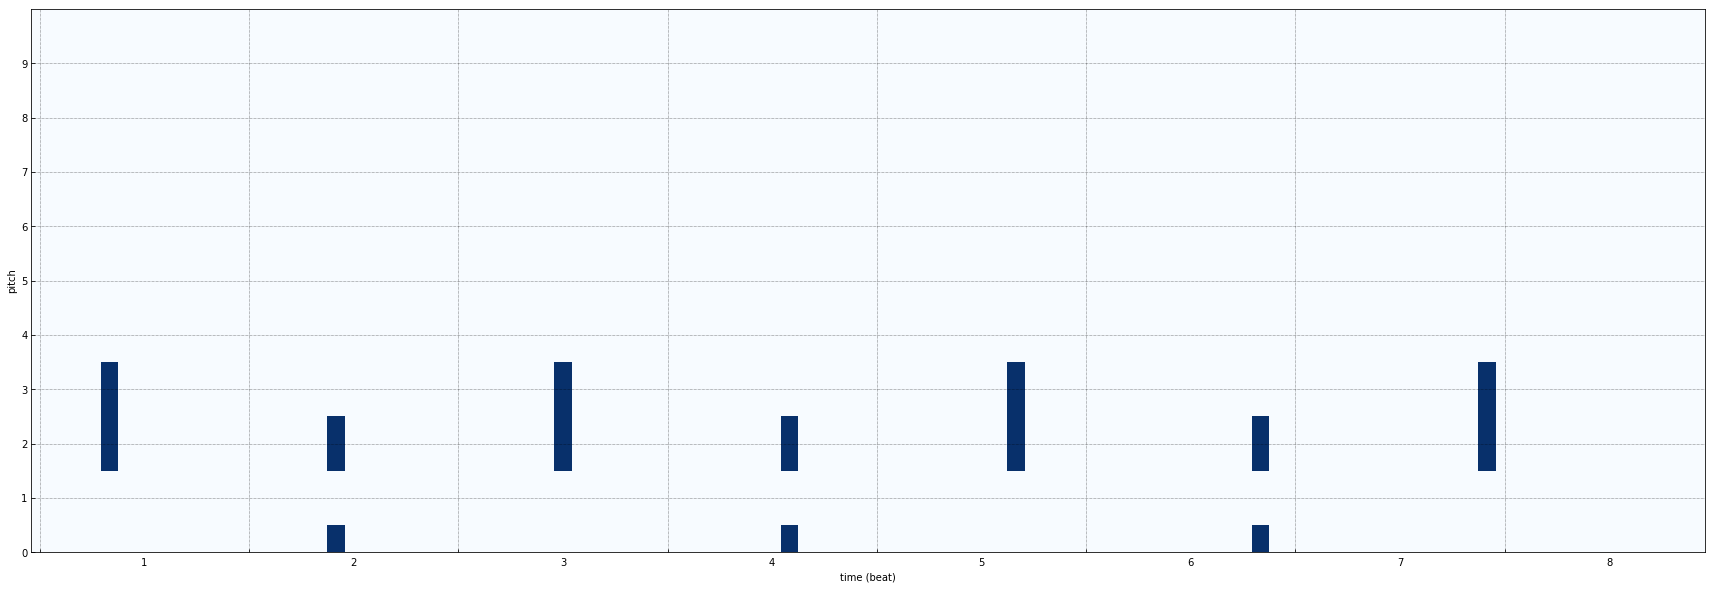

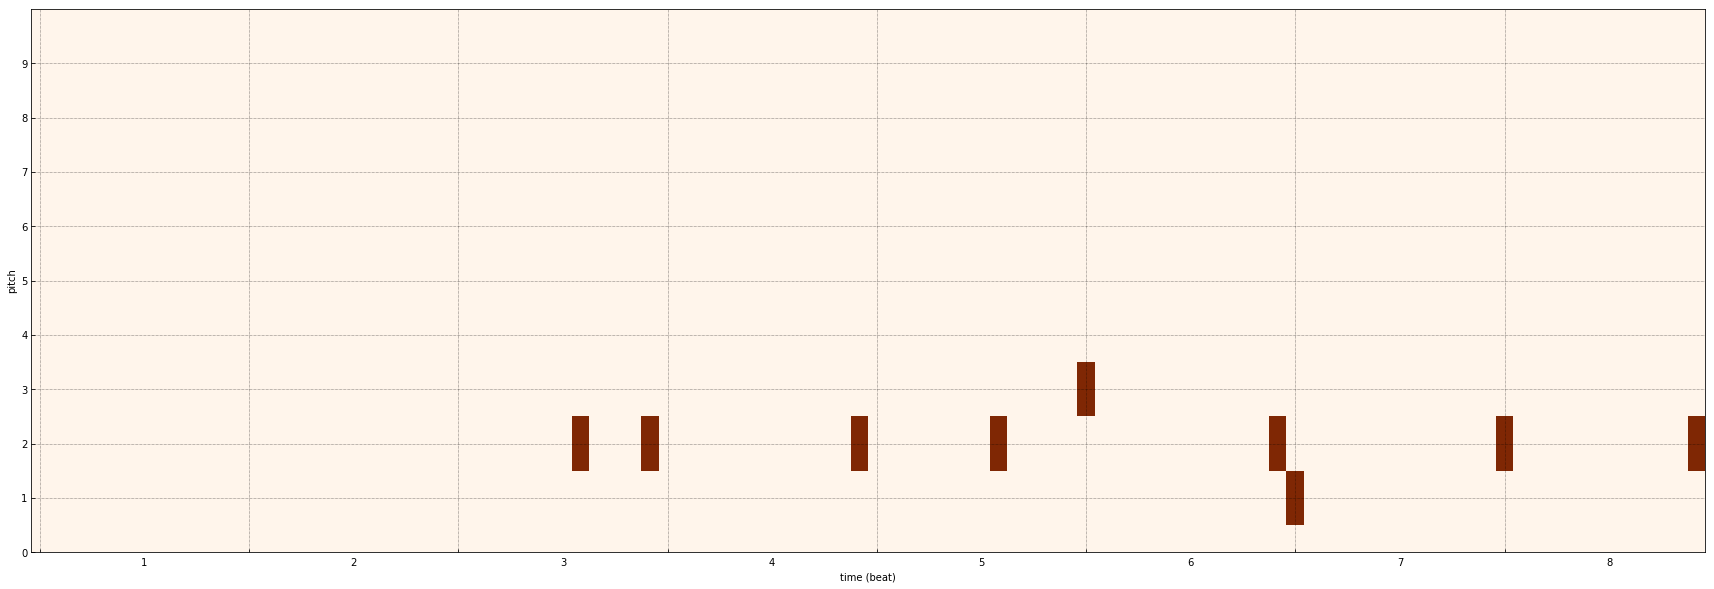

0.99991214 2.3784033e-07


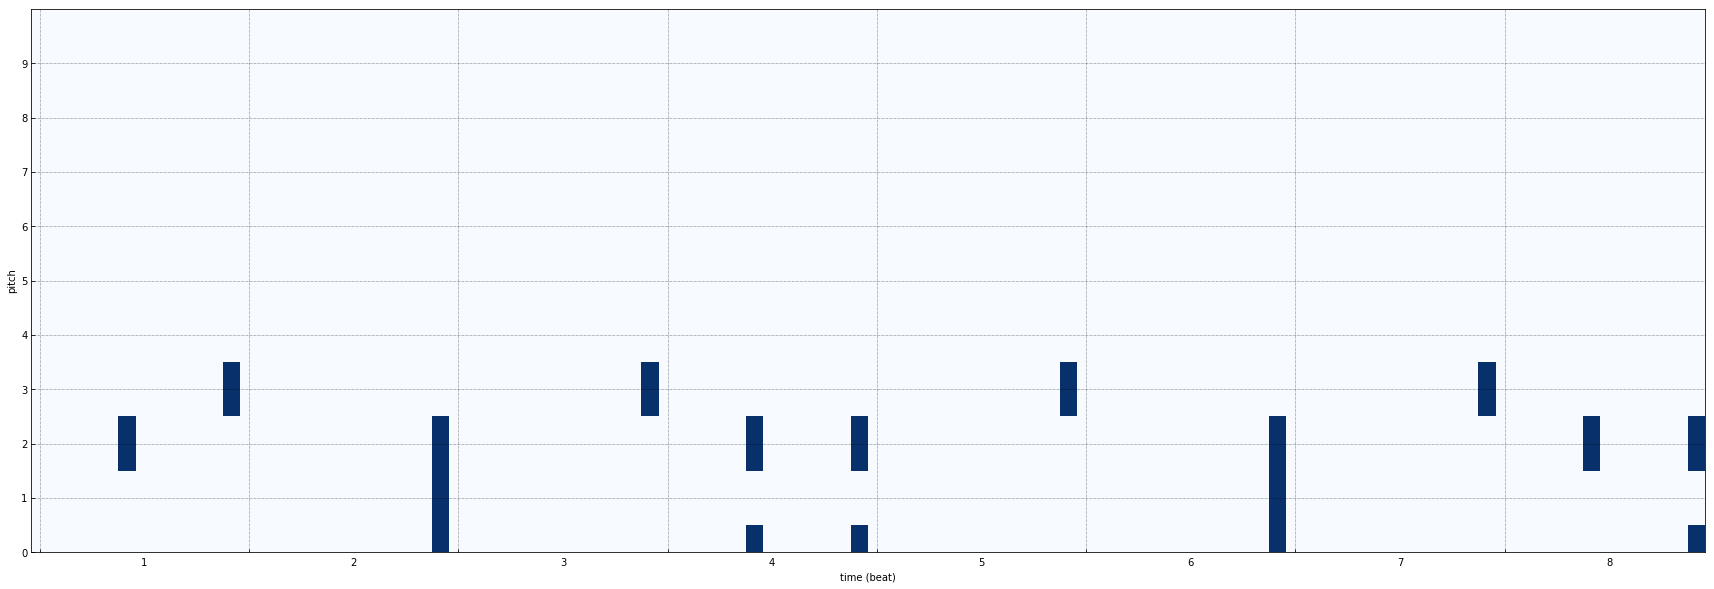

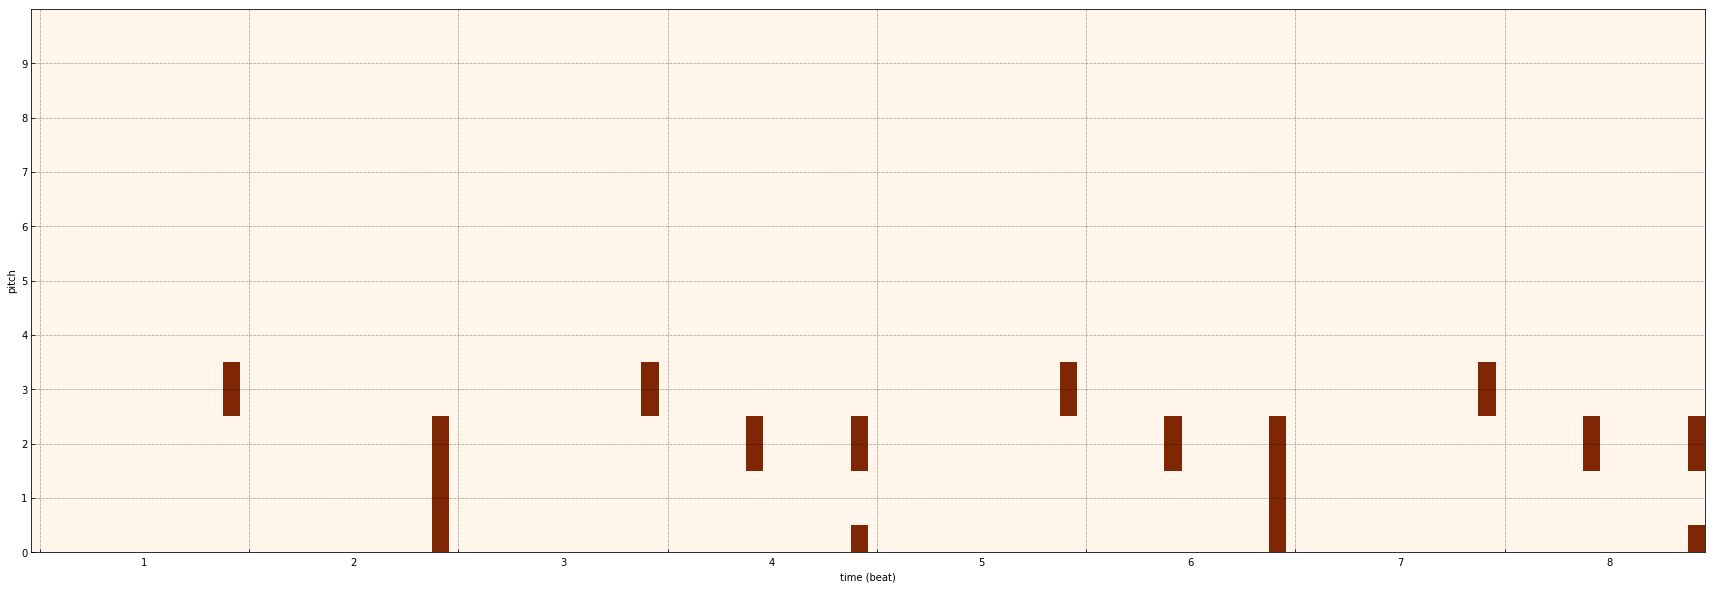

In [15]:
for batch_i, data in enumerate(test_loader):
    if batch_i > 0:
        break
    with torch.no_grad():
        data = Variable(data[0]).type(torch.float32).to(device)
        data_out = vae(data)
        
        
        for i in range(len(data)):
            if i < 20:
                data_i = data[i].cpu().data.numpy()
                data_o = data_out[i].cpu().data.numpy()
                print(data_o.max(), data_o.min())
                data_o = np.where(data_o > 0.2, 1, 0)
                pltReducedDrumTrack(data_i)
                pltReducedDrumTrack(data_o, cmap='Oranges')